In [4]:
import os

import matplotlib.pyplot as plt
import random
from pennylane import numpy as np
from tqdm import tqdm
#from qbmqsp.qbm import QBM
from qbmqsp.utils import construct_multi_fcqbm_pauli_strings
from gen_data import xxz_gibbs_state, basis_encoding, gen_boltzmann_dist, gen_discrete_gauss_dist
from qbmqsp.src.utils import import_dataset, split_dataset_labels, split_data
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score,
                             precision_score, recall_score)
import scipy.linalg as spl

import pennylane as qml
from pennylane import numpy as np
from pennylane.pauli.utils import string_to_pauli_word

from qbmqsp.hamiltonian import Hamiltonian
from qbmqsp.qsp_phase_engine import QSPPhaseEngine
from qbmqsp.qevt import QEVT
from qbmqsp.rel_ent import relative_entropy



import itertools

from functools import partial

In [5]:
def generate_pauli_strings_tfim(num_qubits,n_visible,restricted=True):
    """
    Generate Pauli strings for a transverse field Ising model as a 
    boltzmann machine .
    
    Parameters:
    num_qubits (int): Number of qubits in the quantum Boltzmann machine.
    n_visible (int): Number if visible units.
    
    Returns:
    list: List of Pauli strings representing the Hamiltonian.
    """
    pauli_strings = []

    # Local transverse field terms (X_i)
    for i in range(num_qubits):
        pauli_string = ['I'] * num_qubits
        pauli_string[i] = 'Z'
        pauli_strings.append(''.join(pauli_string))

    # Interaction terms (Z_i Z_j)
    for i, j in itertools.combinations(range(num_qubits), 2):
        if restricted:
            if i<n_visible and j>=n_visible:
                pauli_string = ['I'] * num_qubits
    
                pauli_string[i] = 'Z'
                pauli_string[j] = 'Z'
                pauli_strings.append(''.join(pauli_string))
        else:
            if i<n_visible:
                
                pauli_string = ['I'] * num_qubits
                
                pauli_string[i] = 'Z'
                pauli_string[j] = 'Z'
                   
                pauli_strings.append(''.join(pauli_string))       
    return pauli_strings

generate_pauli_strings_tfim(7,3,False)   

['ZIIIIII',
 'IZIIIII',
 'IIZIIII',
 'IIIZIII',
 'IIIIZII',
 'IIIIIZI',
 'IIIIIIZ',
 'ZZIIIII',
 'ZIZIIII',
 'ZIIZIII',
 'ZIIIZII',
 'ZIIIIZI',
 'ZIIIIIZ',
 'IZZIIII',
 'IZIZIII',
 'IZIIZII',
 'IZIIIZI',
 'IZIIIIZ',
 'IIZZIII',
 'IIZIZII',
 'IIZIIZI',
 'IIZIIIZ']

In [20]:
import seaborn as sns

def evaluate_qbm(qbm,testing_dataset,cluster,plot=False,quantile=0.95,method='min'):


    #training_data=numpy.expand_dims(training_data[:,0],axis=1)
    outliers = qbm.get_binary_outliers(
    dataset=testing_dataset, outlier_index=cluster)

    #outliers=numpy.expand_dims(outliers[:,0],axis=1)
    

    points = qbm.get_binary_cluster_points(
    dataset=testing_dataset, cluster_index=cluster-1)

    #points=numpy.expand_dims(points[:,0],axis=1)
    #print(points)
    predict_points_cluster = np.zeros(len(points), dtype=int)
    predict_points_outliers = np.zeros(len(outliers), dtype=int)
    qbm.calculate_outlier_threshold(quantile, method)
    print("Outlier threshold: ", qbm.outlier_threshold)
    print("Calculate outlier Energy")

    testing_data, testing_labels = split_dataset_labels(testing_dataset)
#testing_data=numpy.expand_dims(testing_data[:,0],axis=1)

    outlier_energy = []
    for index, outlier in enumerate(tqdm(outliers), 0):
        outlier = np.reshape(outlier, (qbm.dim_input))
        predict_points_outliers[index], this_outlier_energy = qbm.predict_point_as_outlier(
            outlier,method)
        outlier_energy.append(this_outlier_energy)
    outlier_energy = np.array(outlier_energy)

    o = outlier_energy.reshape((outlier_energy.shape[0]))

    print("Calculate cluster energy")
    cluster_point_energy = []

    for index, point in enumerate(tqdm(points), 0):
        point = np.reshape(point, (qbm.dim_input))
        predict_points_cluster[index], this_cluster_point_energy = qbm.predict_point_as_outlier(
        point,method)
        cluster_point_energy.append(this_cluster_point_energy)
    cluster_point_energy = np.array(cluster_point_energy)

    c = cluster_point_energy.reshape((cluster_point_energy.shape[0]))

    title='test'
#qbmqsp.src.utils.save_output(title="cluster_" + title, object=c)
#QBM.plot_energy_diff([o, c], qbm.outlier_threshold, title + ".pdf")

#QBM.plot_hist(c, o, qbm.outlier_threshold, "qbm_hist" + ".pdf")

########## OUTLIER CLASSIFICATION ##########
    print('Outlier classification: Results...')
    predict_points = np.concatenate(
        (predict_points_cluster, predict_points_outliers))

    print("Predicted points test: ", predict_points)

    true_points = np.concatenate(
        (np.zeros_like(cluster_point_energy), np.ones_like(outlier_energy)))

    accuracy, precision, recall = accuracy_score(true_points, predict_points), precision_score(
        true_points, predict_points), recall_score(true_points, predict_points)
    f1 = f1_score(true_points, predict_points)
    tn, fp, fn, tp = confusion_matrix(
        true_points, predict_points, labels=[0, 1]).ravel()

    print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}, \nNum True Negative: {tn}, Num False Negative: {fn}, Num True Positive: {tp}, Num False Positive: {fp}')

#print(f'Wallclock time: {(end-start):.2f} seconds')
    lab=cluster-1
    print("Outlier threshold: ", qbm.outlier_threshold)
    print("Average clusterpoint energy: ", np.average(cluster_point_energy))
    print("Outlier energy: ", outlier_energy)
    
    if plot==True:
        plt.figure()
        plt.title('Test Dataset')
        sns.scatterplot(x=testing_data[:,0],y=testing_data[:,1])
        sns.scatterplot(x=testing_data[:,0][testing_labels>lab],y=testing_data[:,1][testing_labels>lab], c='r',palette='coolwarm')
        
    #plt.title('Predicted Points')
    #sns.scatterplot(x=testing_data[:,0],y=testing_data[:,1], hue=predict_points,palette='coolwarm')
    return precision,recall,f1

class QBM():
    """Quantum Boltzmann machine (QBM) based on quantum signal processing.

    Parameters
    ----------
    β, enc:
        Same as attributes.
    h, θ:
        See qbmqsp.hamiltonian.Hamiltonian
    δ, polydeg:
        See qbmqsp.qsp_phase_engine.QSPPhaseEngine

    Attributes
    ----------
    β : float
        Inverse temperature.
    enc : str in {'general', 'lcu'}
        Unitary block encoding scheme.
    H : qbmqsp.hamiltonian.Hamiltonian
        Constructed from parameters (h, θ).
    qsp : qbmqsp.qsp_phase_engine.QSPPhaseEngine
        Constructed from parameters (δ, polydeg).
    qevt : qbmqsp.qevt.QEVT
        Quantum eigenvalue transform to realize matrix function f(A) = exp(- τ * |A|). Updated after each training epoch.
    observables : qml.operation.Observable
        Observables w.r.t which the QBM is measured to optimize via gradient descent.
    aux_wire, enc_wires, sys_wires, env_wires : list[int]
        Quantum register wires of quantum circuit that prepares and measures the QBM.
    """
    
    
    
    
    
    def __init__(self,data,h: list[str], θ: np.ndarray[float], enc: str, δ: float, polydeg: int, β: float, hnodes,epochs=1,restricted=True) -> None:
        if β < 0:
            raise ValueError("__init__: β must not be negative.")
        
        self.epochs=epochs
        self.β = β
        self.enc = enc
        self.H = Hamiltonian(h, θ)
        self.qsp = QSPPhaseEngine(δ, polydeg)
        self.qevt = self._construct_qevt()
        self.aux_wire, self.enc_wires, self.sys_wires, self.env_wires = self._construct_wires()
        self.observables = self._construct_obervables()
        
        self.encoded_data, bits_input_vector, num_features = self.binary_encode_data(data, use_folding=True)
        self.dim_input = bits_input_vector * num_features
        self.quantile=0.95
        self.dim_input=n_visible
        self.n_hidden_nodes=hnodes
        
        self.qubits=self.dim_input+self.n_hidden_nodes
        
        self.restricted=restricted

        if self.restricted:
            self.weights_visible_to_hidden=np.reshape(self.H.θ[self.dim_input+self.n_hidden_nodes:],(self.dim_input,self.n_hidden_nodes))
            self.biases_hidden=self.H.θ[self.dim_input:self.dim_input+self.n_hidden_nodes]
            self.biases_visible=self.H.θ[:self.dim_input]
        else:
            
            self.weights_visible_to_visible,self.weights_visible_to_hidden=self.get_weights(self.H.θ)
            self.biases_hidden=self.H.θ[self.dim_input:self.dim_input+self.n_hidden_nodes]
            self.biases_visible=self.H.θ[:self.dim_input]
        

    def get_binary_cluster_points(self,dataset, cluster_index: int) -> np.ndarray:
        points = np.array([entry[:-1]
                           for entry in dataset if entry[-1] <= cluster_index])

        return self.binary_encode_data(points, use_folding=False)[0]
    
    def get_binary_outliers(self,dataset, outlier_index: int):
        outliers = np.array([entry[:-1]
                            for entry in dataset if entry[-1] >= outlier_index])

        return self.binary_encode_data(outliers, use_folding=False)[0]
  
    def binary_encode_data(self,data, use_folding=False):
        """ Encode a numpy array of form [[numpy.int64 numpy.int64] ...] into a
        list of form [[int, int, int, ...], ...].
        Example: encode [[107  73] [113  90] ...] to
        [[1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1],[1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0] .
        """

        # find out how many bits we need for each feature
        number_bits = len(np.binary_repr(np.amax(data)))
        number_features = data.shape[1]

        binary_encoded = ((data.reshape(-1, 1) & np.array(2 **
                          np.arange(number_bits-1, -1, -1))) != 0).astype(np.float32)
        if use_folding:
            return binary_encoded.reshape(len(data), number_features*number_bits), number_bits, number_features
        else:
            return binary_encoded.reshape(len(data), number_features, number_bits), number_bits, number_features
    
    
    def n_qubits(self, registers: str | set[str] = None) -> int:
        """Return number of qubits per registers.
        
        Parameters
        ----------
        registers : str | set[str]
            Quantum registers whose number of qubits should be returned.
            Must be an element from or a subset of {'aux', 'enc', 'sys', 'env'}.

        Returns
        -------
        n : int
            Number of qubits used per registers.
        """
        if registers is None:
            registers = {'aux', 'enc', 'sys', 'env'}
        elif type(registers) == str:
            registers = {registers}
        if not registers.issubset({'aux', 'enc', 'sys', 'env'}):
            raise ValueError("n_qubits: registers must be an element from or a subset of %r." % {'aux', 'enc', 'sys', 'env'})
        
        n = 0
        if 'env' in registers:
            n += self.qevt.n_qubits('sys')
        registers.discard('env')
        if len(registers) != 0:
            n += self.qevt.n_qubits(registers)
        return n

    def _generate_qsp_phases(self) -> np.ndarray[float]:
        τ = self.β / (1-self.qsp.δ) * self.H.θ_norm()
        φ = self.qsp.generate(τ)
        return φ

    def _construct_qevt(self) -> QEVT:
        φ = self._generate_qsp_phases()
        h_δ, θ_δ = self.H.preprocessing(self.qsp.δ)
        return QEVT(h_δ, θ_δ, self.enc, φ)
    
    def _construct_wires(self) -> tuple[list[int], list[int], list[int], list[int]]:
        wires = list(range(self.n_qubits()))
        aux_wire = wires[: self.n_qubits('aux')]
        enc_wires = wires[self.n_qubits('aux') : self.n_qubits({'aux', 'enc'})]
        sys_wires = wires[self.n_qubits({'aux', 'enc'}) : self.n_qubits({'aux', 'enc', 'sys'})]
        env_wires = wires[self.n_qubits({'aux', 'enc', 'sys'}) : self.n_qubits({'aux', 'enc', 'sys', 'env'})]
        return aux_wire, enc_wires, sys_wires, env_wires

    def _construct_obervables(self) -> list[qml.operation.Observable]:
        n_aux_enc = self.n_qubits({'aux', 'enc'})
        aux_enc_wires = self.aux_wire + self.enc_wires
        proj0 = qml.Projector( [0] * n_aux_enc, aux_enc_wires)

        new_sys_wires = list(range(self.n_qubits('sys')))
        wire_map = dict(zip(self.sys_wires, new_sys_wires))
        observables = [proj0] + [proj0 @ string_to_pauli_word(self.H.h[i], wire_map) for i in range(self.H.n_params)]
        return observables
    
    def _bell_circuit(self) -> None:
        for i, j in zip(self.sys_wires, self.env_wires):
            qml.Hadamard(i)
            qml.CNOT([i, j])

    def probabilistic(self):
        
        bit_strings=[]
        for i in range(2**(self.n_hidden_nodes+self.dim_input)):
        # Convert the number to its binary representation and pad with leading zeros
            bit_string = bin(i)[2:].zfill(self.n_hidden_nodes+self.dim_input)
             
            bit_list = np.array([int(bit) for bit in bit_string])
            bit_strings.append(bit_list) 
            
      
        sample = random.choices(bit_strings, k=1)

        for i,x in enumerate(sample[0]):
            if x==1:
                qml.PauliX(wires=[self.sys_wires[i]])
    
    def _prepare(self) -> None:
        self._bell_circuit()
        #self.probabilistic()
        self.qevt.circuit(self.aux_wire, self.enc_wires, self.sys_wires)
    
    def _measure(self) -> None:
        #return qml.sample(wires=self.aux_wire+self.enc_wires+self.sys_wires)
        return [qml.expval(self.observables[i]) for i in range(len(self.observables))]
    
    
    def get_sample(self,shots=1):
        dev = qml.device(dev_name,shots=shots, wires=self.n_qubits({'aux','enc','sys'}))
        @qml.qnode(dev)
        
        def quantum_circuit():
            
            self._prepare()
            return qml.sample(wires=self.aux_wire+self.enc_wires+self.sys_wires)
        
        sample=quantum_circuit()
        return sample
    
    def get_average_configuration_from_samples(self, samples: list, input_vector=None):
        ''' Takes samples from Annealer and averages for each neuron and connection
        '''

        # unclamped if input_vector == None
        unclamped = input_vector== None

        # biases (row = sample, column = neuron)
        np_samples = np.vstack(
            tuple([np.array(list(sample.values())) for sample in samples]))
        avgs_biases = np.average(np_samples, axis=0)
        avgs_biases_hidden = avgs_biases[self.dim_input:] if unclamped else avgs_biases
        avgs_biases_visible = avgs_biases[:
                                          self.dim_input] if unclamped else input_vector

        # weights
        avgs_weights_visible_to_hidden = np.zeros(
            self.weights_visible_to_hidden.shape)
        if not self.restricted:
            avgs_weights_visible_to_visible = np.zeros(
                self.weights_visible_to_visible.shape)
        for v in range(self.dim_input):
            # visible to hidden connections
            for h in range(self.n_hidden_nodes):
                x, y = (np_samples[:, v], self.dim_input +
                        h) if unclamped else (input_vector[v], h)
                avgs_weights_visible_to_hidden[v, h] = np.average(
                    x*np_samples[:, y])
            # visible to visible connections
            if not self.restricted:
                for v2 in range(v, self.dim_input):
                    x, y = (np_samples[:, v], np_samples[:, v2]) if unclamped else (
                        input_vector[v], input_vector[v2])
                    avgs_weights_visible_to_visible[v, v2] = np.average(x*y)

        if self.restricted:
            return avgs_biases_hidden, avgs_biases_visible, avgs_weights_visible_to_hidden, None
        else:
            return avgs_biases_hidden, avgs_biases_visible, avgs_weights_visible_to_hidden, avgs_weights_visible_to_visible

    def _compute_expvals(self) -> np.ndarray[float]:
        dev = qml.device(dev_name,wires=self.n_qubits({'aux','enc','sys','env'}))
        #dev = qml.device(dev_name, backend=backend,wires=self.n_qubits(),ibmqx_token=token)
        @qml.qnode(dev)
        
        def quantum_circuit():
            self._prepare()
            return self._measure()
        num_repetitions=1
        avg_measurements=np.zeros(self.H.n_params)
        for repetitions in range(num_repetitions):
            
            measurements = quantum_circuit()
            
            success_probabilty = measurements[0]
            
            
            qbm_expvals = measurements[1:] / success_probabilty
            
            avg_measurements+=qbm_expvals
            
            print(success_probabilty, "prob")
        
        
        avg_measurements=avg_measurements/float(num_repetitions)
        
       
        return avg_measurements
    
    def _loss_func(self, ρ0: np.ndarray[float], ρ1: np.ndarray[float]) -> float:
        return relative_entropy(ρ0, ρ1, check_state=True).item()
    
    def assemble(self) -> np.ndarray[float]:
        """Assemble QBM."""
        expH = spl.expm(-self.β * self.H.assemble())
        return expH / np.trace(expH)
    
    
    def get_energy(self,input_vector,k=30,method='min'):
        input_vector=[input_vector]
        new_biases=self.biases_hidden+np.matmul(1-2*np.array(input_vector),self.weights_visible_to_hidden).flatten()
        
        
    # List to store all bit strings
        bit_strings=[]
        p=[]
    # There are 2^n bit strings of length n
        #print(new_biases)
        for i in range(2**self.n_hidden_nodes):
        # Convert the number to its binary representation and pad with leading zeros
            bit_string = bin(i)[2:].zfill(self.n_hidden_nodes)
             
            bit_list = np.array([1-2*int(bit) for bit in bit_string])
            bit_strings.append(bit_list) 
            p.append(np.exp(-self.β*np.dot(bit_list,new_biases)))

        p=np.array(p)
        
        probabilities=p/np.sum(p)
        
        sample = random.choices(bit_strings, weights=probabilities, k=k)
        energies=self.β*np.dot(sample,new_biases)
        
        if method=='min':
            return np.min(energies)    
        else:
            
            return np.average(energies)
            

               

            
     
    
    def free_energy(self,method='min',input_vector=None):
        '''Function to compute the free energy'''

        # calculate hidden term
        
         
         
        hidden_term = self.get_energy(method=method,input_vector=input_vector)

        # calculate visible_term
        # visible bias
        visible_term = self.β*np.dot(
            1-2*np.array(input_vector), self.H.θ[:self.dim_input]) #/beta
        
        

        return hidden_term + visible_term
    
    def calculate_outlier_threshold(self, quantile=0.95,method='min'):
        
        self.quantile = quantile
        energy_func=partial(self.free_energy,method)
        
        energies = np.apply_along_axis(
            energy_func, axis=1, arr=self.encoded_data)
        
        self.outlier_threshold = np.quantile(energies, self.quantile)
        
        
    
    
    
    
    def get_average_configurations(self,input_vector=None):
        '''
        Function for giving averge configurations of all qubits for the gibbs state of the system.
        Gives configuration over hidden units only, if input vector is clamped at a certain value.
       
    
        Parameters:
        input vector (np.ndarray)
        
    
        Returns:
        list: List of expectation values of hamilatonian terms.
        '''
        
        
        # unclamped values
        if input_vector is None:
            
            qbm_expvals=self._compute_expvals()
            
            return qbm_expvals
        
        # clamped values
        
        
        if self.restricted:
            self.weights_visible_to_hidden=np.reshape(self.H.θ[self.dim_input+self.n_hidden_nodes:],(self.dim_input,self.n_hidden_nodes))
            self.biases_hidden=self.H.θ[self.dim_input:self.dim_input+self.n_hidden_nodes]
            self.biases_visible=self.H.θ[:self.dim_input]
        else:
            
            self.weights_visible_to_visible,self.weights_visible_to_hidden=self.get_weights(self.H.θ)
            self.biases_hidden=self.H.θ[self.dim_input:self.dim_input+self.n_hidden_nodes]
            self.biases_visible=self.H.θ[:self.dim_input]
        
        input_vector=[input_vector]
        new_biases=self.biases_hidden+np.matmul(1-2*np.array(input_vector),self.weights_visible_to_hidden).flatten()
        #np.matmul(input_vector, self.weights_visible_to_hidden).flatten()
        
        Q_new=new_biases

        exp_vals=-np.tanh(self.β*new_biases)
        return exp_vals
            
        '''
        
        β, δ, θ_norm = self.β, 0.3, np.linalg.norm(Q_new, ord=1)
        τ = β * θ_norm / (1-δ)
        
        φ = self.qsp.generate(τ)
        #del qsp_phase_engine
         
      
        # New energy configuration only for hidden units
        h=generate_pauli_strings_tfim(self.n_hidden_nodes,self.n_hidden_nodes)
        
        h_δ = h + [self.n_hidden_nodes * 'I']
        θ_δ = np.append(Q_new * (1-δ)/(2*θ_norm), (1+δ)/2)
        encoding='general' 
        qevt = QEVT(h_δ, θ_δ, encoding, φ)
        
        
        
        n_aux, n_enc, n_sys = qevt.n_qubits({'aux'}), qevt.n_qubits({'enc'}), qevt.n_qubits({'sys'})
        wires = list(range(n_aux + n_enc + 2*n_sys))
        aux_wire = wires[: n_aux]
        enc_wires = wires[n_aux : n_aux+n_enc]
        sys_wires = wires[n_aux+n_enc : n_aux+n_enc+n_sys]
        env_wires=wires[n_aux+n_enc+n_sys:]
        
        new_sys_wires = list(range(n_sys))
        wire_map = dict(zip(self.sys_wires, new_sys_wires))
        proj0 = qml.Projector( [0] * (n_aux+n_enc), aux_wire+enc_wires)
        observables = [proj0] + [proj0 @ string_to_pauli_word(h[i], wire_map) for i in range(len(h))]
        
        
        dev = qml.device(dev_name, wires=n_aux+n_enc+2*n_sys)
        #dev = qml.device(, backend=backend,wires=n_aux+n_enc+2*n_sys,ibmqx_token=token)
        @qml.qnode(dev)
        
        
        def qevt_circuit():
            for i, j in zip(sys_wires, env_wires):
                qml.Hadamard(i)
                qml.CNOT([i, j])
            qevt.circuit(aux_wire, enc_wires, sys_wires)
            return [qml.expval(observables[i]) for i in range(len(observables))]
       
        measurements = qevt_circuit()
        success_probabilty = measurements[0]
        qbm_expvals = measurements[1:] / success_probabilty    
        
        return qbm_expvals
    
        '''
            
        
        
    def train_for_one_iteration(self, batch, learning_rate):

        errors = 0
        #errors_biases_visible = 0
        #errors_weights_visible_to_hidden = 0
        #if not self.restricted:
          #  errors_weights_visible_to_visible = 0

        for i,input_vector in enumerate(batch):
            
            
            if i==0:
                unclamped_config = self.get_average_configurations() 
                print(unclamped_config)
            
            clamped_config = self.get_average_configurations(input_vector) # has only expectations over hidden units
            
            # avgs_weights_visible_to_visible_clamped only has a value if not restricted
            print(clamped_config)
            
            # Getting averages for all qubits , avg_visible=input_vector
            
            full_clamped_config=np.zeros_like(unclamped_config)
            
            full_clamped_config[:self.dim_input]=1+(-2)*input_vector   
            full_clamped_config[self.dim_input:self.dim_input+self.n_hidden_nodes]=clamped_config
            
            pos_neg=1-2*input_vector
            if self.restricted:
                
                
                full_clamped_config[self.dim_input+self.n_hidden_nodes:]=np.kron(pos_neg,clamped_config)
            
            else:
                
                
                
                visible=list(pos_neg[j]*pos_neg[i] for j in range(len(pos_neg)) for i in range(j+1,len(pos_neg)))
                hidden=np.kron(pos_neg,clamped_config)
                for i in range(1,self.dim_input+1):
                    for j in range(self.n_hidden_nodes):
                        visible.insert((i-1)*self.n_hidden_nodes+(i)*(self.dim_input-1)-(i-1)+j,hidden[self.n_hidden_nodes*(i-1)+j])
                full_clamped_config[self.dim_input+self.n_hidden_nodes:]=np.array(visible)
            
            errors += full_clamped_config - unclamped_config
            
            
            
            
            
            
            

        errors /= batch.shape[0]
        
        self.H.θ = self.H.θ - learning_rate * errors
                
        self.qevt = self._construct_qevt()
                
       
        
        
        return np.average(errors[:self.dim_input]**2)
    
    
    
    
    def train_model(self, batch_size=8, learning_rate=0.005,save=False):
        
        data = self.encoded_data
        
        weights=[]
        batch_num = data.shape[0] // batch_size
        diff = data.shape[0] % batch_size
        qbm.batch_size=batch_size
        if diff:
            
        
            data = data[:-diff]
            last_batch = data[data.shape[0] - diff:]
        
        
        
        batches = np.vsplit(data, batch_num)
        
        if diff:
            batches.append(last_batch)
              
        losses=[]
        
        for epoch in range(1, self.epochs+1):
            print(f'Epoch {epoch}')
            batch_errors = None
            batchnum = 1
            errors_epoch=[]
            for batch in tqdm(batches):
                    print(batch)
                    errors = self.train_for_one_iteration(batch, learning_rate)
                    print(errors)
                    if type(batch_errors) is np.ndarray:
                        batch_errors = np.hstack((batch_errors, errors))
                    else:
                        batch_errors = errors
                    #self.save_weights(
                        #f'e{epoch}_b{batchnum}_{self.paramstring}')
                    batchnum += 1
               
                    #self.save_weights(
                     #   f'e{epoch}_b{batchnum}_{self.paramstring}')
                    #raise e
                    errors_epoch.append(errors)
            
            losses.append(errors_epoch)
            weights.append(self.H.θ)
            if save==True:
                try:
                    np.savez(f'./epoch{epoch}_weights_h{self.n_hidden_nodes}_v{self.dim_input}_lr{self.learning_rate}_e{self.epochs}',self.H.θ)
                    np.savez(f'./epoch{epoch}_losses_h{self.n_hidden_nodes}_v{self.dim_input}_lr{self.learning_rate}_e{self.epochs}',errors_epoch)
                except:
                    print('error_saving')
        self.calculate_outlier_threshold(self.quantile)
        
        
        
        return losses, weights 
    
    #self.error_container.add_error(batch_errors)
        #self.error_container.plot("qbm_errors" + self.paramstring)
        #self.save_weights(title="final_weights_qbm" + self.paramstring)
        # make list of values of the error dicts
        
        #self.calculate_outlier_threshold(self.quantile)
       
    def predict_point_as_outlier(self, input,method):
        energy = self.free_energy(method,input)
        if energy >= self.outlier_threshold:
            return 1, energy
        return 0, energy
        
    
    def get_weights(self,Q):
        weights_vh_vv=list(Q[self.dim_input+self.n_hidden_nodes:])
            
        for i in range(1,self.dim_input+1):
            for j in range(i):
                weights_vh_vv.insert((self.dim_input+self.n_hidden_nodes)*(i-1)+j,0)
            
        weights_vh_vv=np.array(weights_vh_vv)
        weights_visible_to_visible=weights_vh_vv.reshape(self.dim_input,self.dim_input+self.n_hidden_nodes)[:,0:self.dim_input]
        weights_visible_to_hidden=weights_vh_vv.reshape(self.dim_input,self.dim_input+self.n_hidden_nodes)[:,self.dim_input:]
    
        return weights_visible_to_visible,weights_visible_to_hidden
    
    def save_model(path,dataset_name):
         path=Path(path/dataset)
         path.mkdir(exist_ok=True)
         np.savez(f'_e{qbm.epochs}_h{qbm.n_hidden_nodes}_v{qbm.dim_input}_b{qbm.batch_size}',qbm.H.θ)
        
     
    

    

[ 2  0  0  0  1  2  1  2  1  2  0  1  2  1  0  1  2  0  0  2  1  1  1  0
  3  3  1  1  1  2  3  3  0  0  2  1  1  0  3  2  3  2  1  5  3  0  2  2
  1  3  3  3  2  1  0  3  1  0  1 10  2  1  0  2  1  3  1  0  3  3  2  3
  1  2  1  0  3  1  3  1  3  3  2  3  3  3  3  3  2  3  0  0  0  2  3  2
  2  0  2  2  1  2  1  3  0  3  2  2  0  2  1  2  3  0  1  2  0  1  0  3
  3  1  2  2  1  3  0  2  2  1  3  1  3  2  1  2  1  1  3  0  0  1  3  0
  0  3  3  2  1  3  3  3  2  2  2  3  2  0  3  1  3  3  3  1  1  2  3  0
  1  1  0  0  0  1  1  1  2  3  0  2  2  3  2  2  1  2  2  0  0  1  3  1
  3  0  2  2  1  1  1  0  2  1  3  0  1  3  2  8  2  1  0  1  2  0  0  2
  2  0  2  3  0  1  3  0  1  2  0  1  3  1  0  0  2  0  3  3  3  1  2  0
  2  0  0  1  3  0  2  3  2  0  3  3  0  0  2  0  3  0  1  1  3  0  3  3
  3  3  2  0  0  2  3  2  1  0  0  2  2  2  1  2  2  0  3  0  2  0  1  1
  3  3  1  0  2  0  1  1  0  3  2  0  0  0  1  0  0  2  2  3  0  0  1  2
  1  2  0  3  2  3  3  0  1  2  3  0  0  0  0  0  0

<Axes: title={'center': 'Testing Data'}>

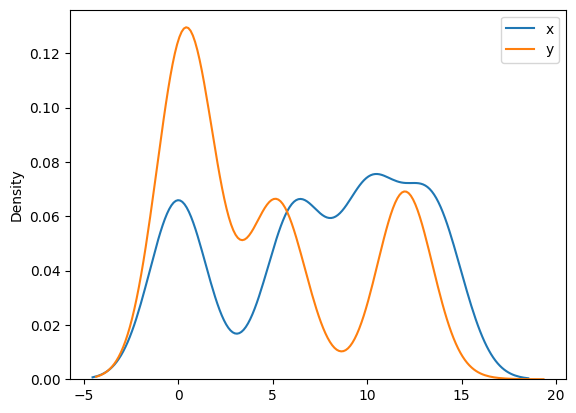

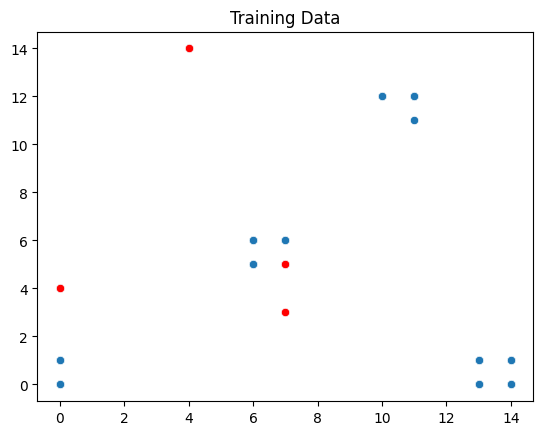

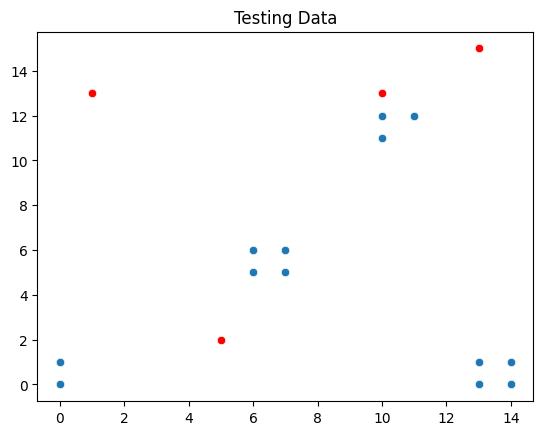

In [21]:
CLUSTER=4
PATH= '../../datasets/l_o8_c4_d2_p200_1.npy'

data = import_dataset(PATH)
training_dataset, testing_dataset = split_data(data, CLUSTER)

training_data, training_labels = split_dataset_labels(training_dataset)
testing_data,testing_labels=split_dataset_labels(testing_dataset)

print(testing_labels)
import seaborn as sns
import numpy
sns.kdeplot(testing_data[:,0],label='x')
sns.kdeplot(testing_data[:,1],label='y')
plt.legend()
plt.figure()
#training_labels
lab=CLUSTER-1
#sns.scatterplot(x=training_data[:,0],y=training_data[:,1])
#sns.scatterplot(c='r',x=training_data[:,0][training_labels==lab],y=training_data[:,1][training_labels==lab])

plt.title('Training Data')
sns.scatterplot(x=training_data[:,0],y=training_data[:,1])
sns.scatterplot(c='r',x=training_data[:,0][training_labels>lab],y=training_data[:,1][training_labels>lab])
plt.figure()
plt.title('Testing Data')
sns.scatterplot(x=testing_data[:,0],y=testing_data[:,1])
sns.scatterplot(c='r',x=testing_data[:,0][testing_labels>lab],y=testing_data[:,1][testing_labels>lab])

In [22]:


np.random.seed(seed=1)
random.seed(1)
#dev_name='qiskit.ibmq'
data = import_dataset(PATH)
training_dataset, testing_dataset = split_data(data, CLUSTER)
training_data, training_labels = split_dataset_labels(training_dataset)
testing_data,testing_labels=split_dataset_labels(testing_dataset)

import numpy
#training_data=numpy.expand_dims(training_data[:,0],axis=1)
#training_data=training_data[0::]
n_hidden_units=1
n_visible=8
n_qubits = n_visible+n_hidden_units

restricted=False
h = generate_pauli_strings_tfim(n_qubits,n_visible,restricted)
print(h)
nparams = len(h)

θ_init =np.random.rand(nparams)/nparams#np.loadtxt('./weights_7_3_un.txt')
enc = 'general'
δ = 0.3
polydeg = 10
β = 1.0
learning_rate = 0.005
epochs = 2


dev_name='default.qubit'
#dev_name='lightning.qubit'

qbm = QBM(training_data,h, θ_init, enc, δ, polydeg, β,n_hidden_units,epochs,restricted)

errors,weights=qbm.train_model(9,learning_rate)
#evaluate_qbm(qbm,testing_dataset,4,plot=True)

['ZIIIIIIII', 'IZIIIIIII', 'IIZIIIIII', 'IIIZIIIII', 'IIIIZIIII', 'IIIIIZIII', 'IIIIIIZII', 'IIIIIIIZI', 'IIIIIIIIZ', 'ZZIIIIIII', 'ZIZIIIIII', 'ZIIZIIIII', 'ZIIIZIIII', 'ZIIIIZIII', 'ZIIIIIZII', 'ZIIIIIIZI', 'ZIIIIIIIZ', 'IZZIIIIII', 'IZIZIIIII', 'IZIIZIIII', 'IZIIIZIII', 'IZIIIIZII', 'IZIIIIIZI', 'IZIIIIIIZ', 'IIZZIIIII', 'IIZIZIIII', 'IIZIIZIII', 'IIZIIIZII', 'IIZIIIIZI', 'IIZIIIIIZ', 'IIIZZIIII', 'IIIZIZIII', 'IIIZIIZII', 'IIIZIIIZI', 'IIIZIIIIZ', 'IIIIZZIII', 'IIIIZIZII', 'IIIIZIIZI', 'IIIIZIIIZ', 'IIIIIZZII', 'IIIIIZIZI', 'IIIIIZIIZ', 'IIIIIIZZI', 'IIIIIIZIZ', 'IIIIIIIZZ']

Starting MATLAB engine.. Done.


Stopping MATLAB engine ... Done.

Epoch 1


  0%|                                                                                           | 0/45 [00:00<?, ?it/s]

[[0. 1. 1. 0. 0. 1. 1. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
0.4236394421601153 prob
[-0.0068827  -0.01912804 -0.00251043 -0.01575221 -0.00538859 -0.01722931
 -0.00743416 -0.01704549 -0.00719625 -0.00433484 -0.01711778 -0.00555596
 -0.01681234 -0.01646777 -0.00293666 -0.00343414 -0.00389897 -0.00204862
 -0.00698082  0.00086204 -0.00096835 -0.0147113  -0.0175087  -0.00071121
 -0.00339113 -0.00322635 -0.02063393 -0.01555562 -0.0116785  -0.00638256
 -0.01840022 -0.00861324 -0.01968285 -0.01450941 -0.01022944 -0.00121784
 -0.02204637 -0.00186935 -0.00391464 -0.00832075 -0.00761152 -0.00228516
 -0.01503944 -0.00290462 -0.01437661]
[-0.02569363]
[-0.02405177]
[-0.00547032]
[-0.02405177]
[-0.05765944]
[0.00142546]
[-0.01981778]
[0.00142546]
[-0.03175743]


  2%|█▊                                                                                 | 1/45 [00:04<03:05,  4.22s/it]

0.20155214444328753
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 1. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 1.]]
0.4320309092847515 prob
[-0.00865139 -0.01987075 -0.00454372 -0.01545551 -0.00362011 -0.01785787
 -0.00326889 -0.01292014 -0.00753192 -0.00446304 -0.01646057 -0.00217778
 -0.01501854 -0.01713647 -0.00607959 -0.00648665 -0.00390265 -0.0024113
 -0.00735375 -0.00341012 -0.0027826  -0.01393634 -0.01693083 -0.00065861
 -0.00530115 -0.00141066 -0.01634093 -0.01609125 -0.01224357 -0.00451572
 -0.01851398 -0.00935651 -0.02033089 -0.01526587 -0.00718812 -0.00079421
 -0.02130427 -0.00180911 -0.00346092 -0.00785574 -0.00457122 -0.00258013
 -0.01518641 -0.00318232 -0.01462293]
[-0.05274937]
[-0.01934245]
[-0.0037939]
[-0.02412576]
[-0.03032632]
[-0.02394847]
[-0.03032632]
[-0.01934245]
[0.00378331]


  4%|███▋                                                                               | 2/45 [00:07<02:48,  3.92s/it]

0.226922528974227
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.45012374683619144 prob
[-0.00940268 -0.02084031 -0.00668167 -0.01166747 -0.0008869  -0.01737902
  0.00070692 -0.01135958 -0.00788929 -0.00364979 -0.0145566  -0.00155828
 -0.01325291 -0.01791093 -0.00802631 -0.0082378  -0.00394984 -0.00034755
 -0.00702972 -0.00663676 -0.00347271 -0.01347389 -0.01648498 -0.00072922
 -0.00855561 -0.00078762 -0.0132034  -0.01663619 -0.01530305 -0.0025807
 -0.01878739 -0.01024547 -0.01743754 -0.01245946 -0.004394    0.00095004
 -0.02205173 -0.00201287 -0.0017952  -0.00871811 -0.00390625 -0.00277673
 -0.01540011 -0.00358553 -0.01489766]
[-0.00103273]
[-0.00103273]
[-0.00103273]
[-0.00103273]
[-0.01812722]
[-0.02002825]
[0.00415594]
[-0.02002825]
[-0.00103273]


  7%|█████▌                                                                             | 3/45 [00:11<02:35,  3.70s/it]

0.3792005383059297
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
0.4355883470967809 prob
[-0.00708466 -0.02275381 -0.01009811 -0.00714096  0.00169439 -0.02023572
  0.00593987 -0.01438449 -0.00786772 -0.00682697 -0.01631638  0.00155332
 -0.0089781  -0.01965339 -0.00612566 -0.01231643 -0.0038595   0.00168744
 -0.0077797  -0.01072844 -0.00134327 -0.01533425 -0.0117126  -0.00078452
 -0.0128893  -0.00118198 -0.00707925 -0.01969036 -0.01407139 -0.00068503
 -0.0186053  -0.01473157 -0.0126067  -0.0141921  -0.00492883  0.00383131
 -0.02724683 -0.00184556 -0.00485433 -0.00854374 -0.00666967 -0.00265972
 -0.01533011 -0.00361841 -0.0146283 ]
[-0.01949872]
[-0.04832622]
[-0.02500361]
[-0.01949872]
[0.00355592]
[-0.00605651]
[-0.01979655]
[-0.02500361]
[-0.03262562]


  9%|███████▍                                                                           | 4/45 [00:15<02:31,  3.70s/it]

0.22321201484169695
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]]
0.43632663613582967 prob
[-0.00912862 -0.02355173 -0.00976421 -0.00578336  0.00428145 -0.0183379
  0.01103857 -0.01272933 -0.00808173 -0.00461571 -0.0156328   0.00349323
 -0.00853233 -0.02028109 -0.00809773 -0.01527163 -0.00367226  0.00088836
 -0.00468276 -0.01393625 -0.00347357 -0.01596793 -0.01108816 -0.00089022
 -0.01620816  0.00188389 -0.00278142 -0.01913901 -0.01455062 -0.00141838
 -0.01889964 -0.01691315 -0.01079732 -0.0137793  -0.0008022   0.00672952
 -0.02765863 -0.0020382  -0.00322722 -0.00833382 -0.00488103 -0.00289897
 -0.01535696 -0.00399183 -0.01471568]
[-0.01689173]
[-0.01490778]
[-0.01689173]
[-0.04346402]
[-0.02672488]
[-0.01490778]
[-0.01689173]
[0.00325552]
[0.00054835]


 11%|█████████▏                                                                         | 5/45 [00:18<02:23,  3.60s/it]

0.1976941617304786
[[0. 1. 1. 1. 0. 1. 1. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 0.]]
0.4426490185073106 prob
[-0.00985853 -0.02195759 -0.01071895 -0.00325849  0.00541807 -0.01792286
  0.01616606 -0.01230436 -0.00820731 -0.00403339 -0.01237963  0.00239281
 -0.00544117 -0.01834692 -0.00887501 -0.01817052 -0.00352961  0.00114189
 -0.0007613  -0.01599084 -0.00440742 -0.01421618 -0.00941146 -0.00106081
 -0.01712395  0.00498017  0.00144415 -0.02001495 -0.01759526 -0.00207881
 -0.01915676 -0.01659776 -0.00774951 -0.01094698  0.00324568  0.00848953
 -0.03073297 -0.00236797 -0.00279831 -0.01069416 -0.00439479 -0.0030671
 -0.01534195 -0.00421162 -0.01470966]
[-0.01911794]
[-0.01316788]
[-0.03967672]
[-0.01115632]
[-0.01316788]
[0.00502881]
[-0.01316788]
[-0.02177796]
[-0.01775193]


 13%|███████████                                                                        | 6/45 [00:21<02:18,  3.55s/it]

0.21984698445767087
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 1. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
0.4402638405827948 prob
[-0.01043724 -0.02006611 -0.01419791 -0.00025837  0.00547256 -0.01996588
  0.02010415 -0.00927321 -0.00834437 -0.00598528 -0.00891813  0.00132148
 -0.00085996 -0.01627237 -0.01088335 -0.02109021 -0.00340641  0.0015122
  0.00078668 -0.01911471 -0.00504416 -0.01094999 -0.00772754 -0.00113531
 -0.01787891  0.00677748  0.00566709 -0.02210167 -0.0205018  -0.00146487
 -0.01924649 -0.01614293 -0.00333145 -0.01051221  0.00610574  0.00779035
 -0.03250258 -0.00252662 -0.0034941  -0.01292881 -0.002758   -0.00318513
 -0.01505168 -0.00426385 -0.01473397]
[-0.008458]
[0.00666713]
[-0.03475816]
[-0.01281994]
[-0.01056661]
[-0.01056661]
[-0.03013744]
[-0.01056661]
[-0.03698134]


 16%|████████████▉                                                                      | 7/45 [00:25<02:14,  3.55s/it]

0.23164878803043296
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
0.4274703294336507 prob
[-0.00981024 -0.01805507 -0.01515188  0.00389156  0.00657915 -0.02190088
  0.023631   -0.00649654 -0.00842039 -0.00680881 -0.00706053  0.00273475
  0.00330282 -0.01550803 -0.01166047 -0.02281501 -0.00332259  0.00153875
  0.0034894  -0.02097199 -0.00572466 -0.00780896 -0.0061103  -0.0011596
 -0.01996421  0.0095197   0.00989221 -0.02169853 -0.02103077 -0.0009755
 -0.01940577 -0.01938826 -0.00016508 -0.00887008  0.00765875  0.00837895
 -0.03285414 -0.00291248 -0.00413471 -0.0150329  -0.00114365 -0.00330143
 -0.01489813 -0.00428654 -0.01467029]
[-0.03547025]
[0.0071925]
[-0.009058]
[-0.03547025]
[-0.009058]
[-0.009058]
[0.0071925]
[-0.00693168]
[-0.009058]


 18%|██████████████▊                                                                    | 8/45 [00:29<02:11,  3.55s/it]

0.3267275575472899
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 1. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
0.4075620151803014 prob
[-0.00916403 -0.01478617 -0.01740971  0.00935554  0.00623128 -0.02388646
  0.02832517 -0.00499367 -0.00839151 -0.00905325 -0.0039171   0.00261528
  0.00865625 -0.01240459 -0.0113494  -0.02568731 -0.00329778  0.00147506
  0.00601045 -0.02261931 -0.00530372 -0.0046811  -0.00206498 -0.00123337
 -0.02204229  0.01239985  0.01502437 -0.0238801  -0.02140241 -0.00055922
 -0.01961696 -0.02140429  0.00546781 -0.00729901  0.01030512  0.00886248
 -0.03557763 -0.00339204 -0.00590038 -0.01622247  0.00017131 -0.00344232
 -0.01477432 -0.00416482 -0.01453568]
[-0.04026147]
[0.00773428]
[-0.00533917]
[-0.04026147]
[-0.04026147]
[-0.01158545]
[0.00773428]
[-0.04026147]
[-0.0053975]


 20%|████████████████▌                                                                  | 9/45 [00:32<02:04,  3.45s/it]

0.20241865529920375
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
0.37538125388910215 prob
[-0.00960772 -0.01770516 -0.01671246  0.00968223  0.01008908 -0.02289948
  0.03153138 -0.00329756 -0.0083767  -0.00809904 -0.0071233   0.00710469
  0.0087774  -0.01540426 -0.01285987 -0.02938118 -0.00295783  0.00069823
  0.00776274 -0.02645799 -0.00602317 -0.00637799 -0.0037879  -0.00107797
 -0.02613256  0.01383126  0.02025692 -0.02193937 -0.01916041 -0.00139441
 -0.01964528 -0.02570167  0.00470153 -0.01031933  0.01189863  0.01159736
 -0.03415854 -0.0033326  -0.00420064 -0.01445189  0.00077182 -0.00368428
 -0.014606   -0.00440038 -0.01453766]
[-0.00259264]
[-0.00496058]
[-0.00496058]
[-0.04114016]
[0.01160957]
[-0.01256515]
[-0.04114016]
[-0.04114016]
[-0.00496058]


 22%|██████████████████▏                                                               | 10/45 [00:35<02:00,  3.43s/it]

0.1883884879891633
[[0. 1. 1. 1. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]]
0.339361899548251 prob
[-0.01274235 -0.01797699 -0.01586599  0.00998456  0.01144465 -0.02203843
  0.03614696 -0.00159621 -0.00829369 -0.00722376 -0.00761406  0.00879051
  0.00913917 -0.0158957  -0.01575307 -0.03312816 -0.00267757 -0.00283235
  0.01192585 -0.03030549 -0.00930714 -0.00670527 -0.00325335 -0.00094484
 -0.03031273  0.01784002  0.02532615 -0.02134232 -0.01939325 -0.00456522
 -0.0199758  -0.02982326  0.00509324 -0.01094594  0.01584217  0.01356954
 -0.03542251 -0.00342946 -0.00373486 -0.01497301  0.00233193 -0.00409368
 -0.01441602 -0.00444378 -0.01445952]
[-0.03011702]
[-0.02951786]
[-0.01097014]
[-0.02951786]
[0.01877578]
[0.01877578]
[0.01877578]
[0.00097214]
[-0.01097014]


 24%|████████████████████                                                              | 11/45 [00:38<01:54,  3.37s/it]

0.3192634667526121
[[1. 0. 1. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 0. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
0.3261916726104545 prob
[-0.00797204 -0.02001986 -0.0192039   0.01186469  0.0150944  -0.02489955
  0.03958832 -0.00252683 -0.00834119 -0.01081064 -0.00972379  0.00910831
  0.01417503 -0.01761058 -0.01276033 -0.03469944 -0.00285682  0.00139202
  0.0130428  -0.03305353 -0.00510529 -0.00745926  0.00085761 -0.00097755
 -0.02974505  0.01575419  0.03032053 -0.02325237 -0.01637764 -0.0039341
 -0.01995962 -0.02924125  0.00790237 -0.01036964  0.01393532  0.01561832
 -0.03657157 -0.00376114 -0.005411   -0.01277062  0.00049277 -0.00398598
 -0.01466491 -0.00433007 -0.01439719]
[-0.02591538]
[-0.00376478]
[0.01486064]
[-0.02591538]
[0.01582104]
[0.01486064]
[-0.03234703]
[-0.04670634]
[-0.01277047]


 27%|█████████████████████▊                                                            | 12/45 [00:42<01:49,  3.31s/it]

0.18335700000286015
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
0.3091613882336646 prob
[-8.55449506e-03 -2.06929588e-02 -2.10992700e-02  1.34809868e-02
  1.74390591e-02 -2.40952490e-02  4.43008913e-02 -2.11503713e-03
 -8.40068983e-03 -1.03171115e-02 -8.05662441e-03  1.18439789e-02
  1.56208110e-02 -1.79883341e-02 -1.33743994e-02 -3.74729585e-02
 -2.72824168e-03  3.06167736e-03  1.10381011e-02 -3.55808484e-02
 -5.67776033e-03 -8.04256010e-03  2.46739580e-03 -1.07144260e-03
 -2.99961758e-02  1.61973381e-02  3.27322443e-02 -2.51810398e-02
 -1.56985770e-02 -3.25705719e-05 -1.97141152e-02 -2.75139954e-02
  9.66649103e-03 -1.34364135e-02  1.64798747e-02  1.82264043e-02
 -3.78011134e-02 -3.80265261e-03 -4.79743288e-03 -1.24546420e-02
  1.08089935e-03 -3.86990180e-03 -1.45905200e-02 -4.50663107e-

 29%|███████████████████████▋                                                          | 13/45 [00:45<01:45,  3.31s/it]

0.14713750321325686
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [1. 0. 1. 1. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.289174310985657 prob
[-0.00925007 -0.01980663 -0.02288456  0.016442    0.01862569 -0.02478916
  0.04787853 -0.00039646 -0.00827028 -0.01104497 -0.00602352  0.01070547
  0.01846331 -0.01707431 -0.01514764 -0.03886711 -0.002711    0.00320285
  0.01368234 -0.03825077 -0.00633969 -0.00605599  0.00401618 -0.00105309
 -0.03171563  0.01775991  0.03643233 -0.02599718 -0.01856671 -0.00070112
 -0.01986269 -0.02812087  0.01374664 -0.01152992  0.01906379  0.01877567
 -0.03935613 -0.00408639 -0.00426387 -0.01436298  0.00128511 -0.00398788
 -0.01430433 -0.00438576 -0.01455134]
[0.01813028]
[-0.04768136]
[-0.01892924]
[-0.03595101]
[-0.01892924]
[0.01813028]
[-0.00964744]
[0.00109725]
[0.01813028]


 31%|█████████████████████████▌                                                        | 14/45 [00:48<01:41,  3.27s/it]

0.2961424270703018
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
0.2630201322745711 prob
[-0.00814633 -0.02284293 -0.02715578  0.01714233  0.02112154 -0.02733603
  0.05251591 -0.00107221 -0.0083508  -0.01413043 -0.0079158   0.01130071
  0.02114105 -0.01972752 -0.01437404 -0.0436335  -0.00272831  0.00522268
  0.01277765 -0.04290512 -0.00556805 -0.00891511  0.0070419  -0.00093873
 -0.03323978  0.01591551  0.04014095 -0.02987932 -0.01648129 -0.00016554
 -0.01966618 -0.02853193  0.01424353 -0.01202183  0.01833794  0.02095504
 -0.04131736 -0.00422288 -0.00700464 -0.01197257  0.00087536 -0.00395372
 -0.01427848 -0.00431586 -0.01445391]
[0.00255333]
[0.01418054]
[-0.02076013]
[-0.02516958]
[-0.01368757]
[0.01418054]
[-0.02157718]
[0.00340034]
[0.00255333]


 33%|███████████████████████████▎                                                      | 15/45 [00:51<01:39,  3.31s/it]

0.20101496935093915
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
0.2433153329443521 prob
[-0.00733947 -0.02337848 -0.02895968  0.02004327  0.02333333 -0.02780545
  0.0570476  -0.00174493 -0.00825821 -0.01491667 -0.00736208  0.01151511
  0.02371959 -0.02000004 -0.01375875 -0.04610455 -0.00274525  0.00674471
  0.01412788 -0.0453397  -0.00507095 -0.00939255  0.00982508 -0.00090174
 -0.03489503  0.01642593  0.04375149 -0.03167153 -0.01696165  0.00029396
 -0.01972275 -0.02909747  0.01715313 -0.0102254   0.01975605  0.02346668
 -0.0435612  -0.00456183 -0.0075278  -0.01180779  0.00018143 -0.00399899
 -0.01427587 -0.00424601 -0.0143138 ]
[0.00416564]
[-0.02425164]
[-0.02425164]
[0.00416564]
[-0.05080319]
[0.00498772]
[-0.02346439]
[0.00416564]
[-0.01315909]


 36%|█████████████████████████████▏                                                    | 16/45 [00:55<01:35,  3.30s/it]

0.16551581208426205
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 1.]]
0.22943286568776305 prob
[-8.05349418e-03 -2.25404273e-02 -3.07050563e-02  2.16299599e-02
  2.43762204e-02 -2.82581480e-02  6.15940317e-02 -5.00158485e-05
 -8.16637671e-03 -1.56321115e-02 -5.35232621e-03  9.28034240e-03
  2.64420096e-02 -1.90921584e-02 -1.44706543e-02 -4.97303622e-02
 -2.75521359e-03  6.86670619e-03  1.79831666e-02 -4.78943852e-02
 -5.78746931e-03 -8.59086008e-03  1.14266684e-02 -7.23031460e-04
 -3.54021560e-02  1.81307215e-02  4.72514359e-02 -3.34527958e-02
 -1.75018614e-02 -1.52277644e-03 -1.99647644e-02 -2.84632344e-02
  1.88112609e-02 -7.24855823e-03  2.24000157e-02  2.50102511e-02
 -4.48626910e-02 -4.80438761e-03 -8.12516211e-03 -1.15780702e-02
  1.59810470e-03 -4.25394053e-03 -1.39594110e-02 -4.14865294e

 38%|██████████████████████████████▉                                                   | 17/45 [00:58<01:31,  3.27s/it]

0.5075936291665888
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 1. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
0.2282098152104945 prob
[-0.0064121  -0.02093357 -0.02748743  0.02518915  0.02877704 -0.02286507
  0.06588767 -0.00085916 -0.00795567 -0.01046544 -0.00146445  0.01186451
  0.02753743 -0.0170673  -0.01279867 -0.05123062 -0.00247308  0.01038667
  0.02040733 -0.04588204 -0.00440007 -0.00700377  0.00923112 -0.000797
 -0.03322887  0.02084245  0.04940842 -0.0308143  -0.01827801  0.00230721
 -0.01980613 -0.02451875  0.02278772 -0.00925774  0.02700594  0.03000212
 -0.04495534 -0.00489788 -0.0031253  -0.0120949   0.00090182 -0.0040025
 -0.0141293  -0.00438649 -0.01435375]
[0.01920926]
[-0.00353244]
[0.01920926]
[0.01920926]
[-0.04894467]
[-0.02961789]
[-0.00353244]
[-0.00353244]
[-0.0091633]


 40%|████████████████████████████████▊                                                 | 18/45 [01:01<01:27,  3.26s/it]

0.2625255813539157
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
0.22048651133066785 prob
[-0.00595121 -0.02045733 -0.02791763  0.02779815  0.03218619 -0.01965652
  0.07035077 -0.00025223 -0.00780121 -0.00755199  0.00274295  0.01209235
  0.02887096 -0.01604259 -0.01228251 -0.05488752 -0.00222953  0.01422723
  0.02068817 -0.04600386 -0.00381988 -0.00654037  0.00719287 -0.0007531
 -0.03090379  0.02127079  0.050371   -0.03138159 -0.02129206  0.00624683
 -0.01926741 -0.01924275  0.02554177 -0.00878691  0.03048775  0.03359286
 -0.04490889 -0.0049783  -0.00031632 -0.01147033  0.00118242 -0.00358269
 -0.01382572 -0.0045153  -0.01445057]
[0.00209814]
[0.00209814]
[0.00142935]
[0.02705924]
[0.02975967]
[0.02705924]
[-0.04893648]
[0.02975967]
[0.00209814]


 42%|██████████████████████████████████▌                                               | 19/45 [01:04<01:25,  3.28s/it]

0.21049563158923432
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 0. 0. 1. 1. 1. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]]
0.20332354476177245 prob
[-0.0052359  -0.01828955 -0.02841346  0.03186661  0.03296531 -0.02037157
  0.0747304   0.00017848 -0.00753902 -0.00831461  0.00453203  0.0134931
  0.03261786 -0.01404721 -0.01174698 -0.05838968 -0.00206919  0.01423407
  0.02323665 -0.04724987 -0.00337381 -0.00446773  0.00877569 -0.00062727
 -0.03259502  0.02415108  0.05507671 -0.03209247 -0.02171111  0.00657568
 -0.01942165 -0.02105125  0.02964909 -0.0093415   0.03293953  0.03521932
 -0.04740828 -0.00519768 -0.00087489 -0.01240782  0.00154248 -0.00361086
 -0.01374697 -0.00424245 -0.01445856]
[0.0047697]
[0.0047697]
[0.0047697]
[0.02477156]
[0.02877014]
[0.02877014]
[0.0047697]
[0.00434145]
[-0.03800796]


 44%|████████████████████████████████████▍                                             | 20/45 [01:08<01:21,  3.28s/it]

0.25802917227819
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]]
0.18655159417200104 prob
[-0.00472819 -0.01715609 -0.03169757  0.03601776  0.03145372 -0.02467374
  0.07820874  0.00184533 -0.00732167 -0.01263007  0.00622695  0.0123484
  0.03659985 -0.01313963 -0.01248893 -0.06068742 -0.00220403  0.01328029
  0.02468757 -0.04975596 -0.00285908 -0.00240547  0.01289772 -0.00054896
 -0.03467555  0.02489944  0.0587477  -0.03617098 -0.0210495   0.00466948
 -0.01973048 -0.0239887   0.03271226 -0.00628026  0.03432924  0.03551343
 -0.05120551 -0.00544233 -0.00366776 -0.01372713  0.00194565 -0.00388989
 -0.01334446 -0.00387882 -0.01415685]
[0.00159061]
[0.00134287]
[0.00159061]
[0.02977204]
[-0.05884293]
[0.00159061]
[0.01047403]
[0.00159061]
[-0.05731669]


 47%|██████████████████████████████████████▎                                           | 21/45 [01:11<01:17,  3.23s/it]

0.32817864151169307
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 1. 0. 1. 0. 1.]]
0.18275016527103716 prob
[-0.00309403 -0.01524793 -0.02948492  0.03843135  0.03512751 -0.02137067
  0.08131505  0.00548866 -0.00714809 -0.00979264  0.00890715  0.01596123
  0.03898319 -0.01132648 -0.011769   -0.05986248 -0.00175943  0.01575701
  0.02620024 -0.04879837 -0.00117785  0.00021556  0.01306911 -0.00056392
 -0.03236742  0.02743493  0.06196885 -0.03307321 -0.02062491  0.0085203
 -0.01902491 -0.02095754  0.03411684 -0.00480296  0.03772928  0.03805916
 -0.04788238 -0.00535871  0.000254   -0.01171721  0.0043744  -0.00347908
 -0.01304262 -0.00408663 -0.01426325]
[0.01321129]
[0.04137902]
[0.03300695]
[0.00500098]
[0.00667784]
[0.03300695]
[0.03300695]
[0.04137902]
[-0.04419503]


 49%|████████████████████████████████████████                                          | 22/45 [01:14<01:13,  3.19s/it]

0.30982515681003786
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 1. 0. 1. 0. 1.]]
0.1701850436348621 prob
[ 0.00032657 -0.01598177 -0.03121199  0.0424014   0.03836124 -0.02175301
  0.08562411  0.00351921 -0.00695507 -0.01056411  0.00908604  0.01763449
  0.04244723 -0.01153471 -0.00875124 -0.06326333 -0.00164616  0.01969544
  0.026206   -0.04988215  0.00171528 -0.00044881  0.01466387 -0.00047476
 -0.03271021  0.02673524  0.06536481 -0.03465881 -0.01990203  0.01116454
 -0.01872806 -0.02034262  0.03810502 -0.00547857  0.03785018  0.04124954
 -0.04972229 -0.00559895 -0.00023412 -0.01048442  0.0027699  -0.00315368
 -0.01325209 -0.00391909 -0.0142477 ]
[0.04435971]
[0.03047264]
[0.03027183]
[-0.05133528]
[0.00230888]
[0.03027183]
[0.03047264]
[0.03027183]
[-0.04765939]


 51%|█████████████████████████████████████████▉                                        | 23/45 [01:17<01:09,  3.17s/it]

0.40273994661416124
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [0. 1. 1. 1. 0. 1. 1. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.15762619111832993 prob
[ 0.0013783  -0.02055788 -0.0341923   0.04509571  0.04288184 -0.02085899
  0.08987913  0.00043923 -0.00680772 -0.01014935  0.00777328  0.01839426
  0.04234827 -0.01505971 -0.00791265 -0.0654424  -0.00155425  0.02384513
  0.02373976 -0.05313713  0.00232792 -0.00474029  0.01622339 -0.00050412
 -0.03525955  0.02367319  0.06641592 -0.03742411 -0.01678284  0.01370608
 -0.01840006 -0.01983591  0.0408625  -0.00836988  0.03795313  0.04530733
 -0.05119337 -0.0055438   0.00033979 -0.00911403  0.00053818 -0.00283508
 -0.01366747 -0.00390085 -0.01431539]
[0.02866044]
[-0.04827976]
[0.02890279]
[-0.02006449]
[-0.06907991]
[0.0006607]
[0.00204137]
[0.0006607]
[0.02866044]


 53%|███████████████████████████████████████████▋                                      | 24/45 [01:20<01:06,  3.16s/it]

0.2604069226881869
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 1. 1. 0. 1. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 1. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
0.14584841141266108 prob
[-0.00037104 -0.02499429 -0.03735261  0.04687665  0.04642787 -0.02013455
  0.09338027  0.00101365 -0.00665405 -0.00967538  0.00699975  0.01768774
  0.04139172 -0.01868091 -0.01060418 -0.06667894 -0.00142252  0.02548343
  0.02264718 -0.0579051   0.00057095 -0.00769723  0.01664737 -0.00050361
 -0.03922026  0.02178702  0.06770582 -0.03943331 -0.01713577  0.01403105
 -0.01836286 -0.02070129  0.0437327  -0.00878768  0.03927894  0.04756365
 -0.05084954 -0.00547444  0.00190808 -0.00878986  0.00016745 -0.00277832
 -0.01340463 -0.00379952 -0.01439221]
[0.00143967]
[-0.04958668]
[0.00329685]
[-0.08005169]
[0.0315935]
[0.01208721]
[0.00329685]
[0.02381568]
[0.02381568]


 56%|█████████████████████████████████████████████▌                                    | 25/45 [01:23<01:02,  3.14s/it]

0.17313176211637818
[[1. 1. 0. 1. 0. 0. 0. 1.]
 [0. 1. 1. 1. 0. 0. 1. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 1. 0. 1. 1. 0.]]
0.13841297234211858 prob
[-2.41469290e-03 -2.45355988e-02 -4.00750587e-02  4.97074422e-02
  4.77017434e-02 -1.84011530e-02  9.59168899e-02  3.98799505e-03
 -6.55832253e-03 -9.12262263e-03  1.09627976e-02  1.75853684e-02
  4.27899701e-02 -1.88314818e-02 -1.24915241e-02 -6.58430984e-02
 -1.11856897e-03  2.69010365e-02  2.08551750e-02 -6.03022120e-02
 -2.38501473e-05 -7.19023280e-03  1.70161444e-02 -5.89144217e-04
 -3.95736116e-02  2.21368203e-02  6.77183828e-02 -4.02721908e-02
 -1.79044252e-02  1.77417531e-02 -1.78713311e-02 -1.90122020e-02
  4.64953276e-02 -5.94864461e-03  4.15439848e-02  4.89709325e-02
 -4.88717477e-02 -5.31488241e-03  3.60032905e-03 -9.16207973e-03
  2.72586943e-03 -2.33153897e-03 -1.27797241e-02 -3.79112772e

 58%|███████████████████████████████████████████████▍                                  | 26/45 [01:26<00:58,  3.10s/it]

0.27316536314716267
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.12983521027460032 prob
[-0.00015801 -0.02908241 -0.04436745  0.0504944   0.05128029 -0.02021277
  0.09821819  0.0020829  -0.00666905 -0.01250817  0.00768419  0.01703486
  0.04542735 -0.02142931 -0.01276642 -0.06821429 -0.00129733  0.02987766
  0.02080741 -0.06522577  0.0006492  -0.00897048  0.0199515  -0.00041156
 -0.0415474   0.01886996  0.07026508 -0.04225016 -0.01694109  0.0170202
 -0.01792496 -0.02089542  0.04926588 -0.0053922   0.04079145  0.04981526
 -0.05064325 -0.00570004  0.00183632 -0.00921285  0.00133703 -0.00247388
 -0.01285121 -0.00355941 -0.01420382]
[-0.04598038]
[0.00020819]
[0.02918105]
[0.00020819]
[-0.04598038]
[0.02918105]
[0.05718877]
[0.00020819]
[0.03003142]


 60%|█████████████████████████████████████████████████▏                                | 27/45 [01:30<00:56,  3.12s/it]

0.20490730072734775
[[1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
0.12136641309772749 prob
[-0.00086193 -0.02685615 -0.04362414  0.0533065   0.05196304 -0.0196367
  0.10258202  0.00471653 -0.00626425 -0.01212116  0.00952586  0.01826758
  0.04796689 -0.01952116 -0.01342586 -0.07067277 -0.00095201  0.02841514
  0.02464956 -0.0665315  -0.00018609 -0.00681897  0.0214172  -0.00019986
 -0.04322086  0.02306273  0.07497985 -0.04192391 -0.01637196  0.01613079
 -0.01823695 -0.02279149  0.052188   -0.00482627  0.04437051  0.05161932
 -0.05091385 -0.00575419  0.00234036 -0.00906862  0.00386606 -0.00258106
 -0.01243673 -0.00321393 -0.01420389]
[0.00702244]
[-0.04983237]
[0.0331644]
[0.06115358]
[-0.04983237]
[-0.0218168]
[0.0331644]
[0.00402413]
[0.06115358]


 62%|███████████████████████████████████████████████████                               | 28/45 [01:33<00:53,  3.12s/it]

0.3180807615832324
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
0.11586582755361345 prob
[-1.53959307e-03 -2.59893807e-02 -4.00242281e-02  5.45717857e-02
  5.52928145e-02 -1.51081155e-02  1.06627614e-01  6.34160667e-03
 -5.65658130e-03 -8.00266302e-03  1.13607226e-02  2.07714749e-02
  4.79282191e-02 -1.86590210e-02 -1.38556338e-02 -7.19288125e-02
 -3.38702101e-04  2.81910647e-02  2.84373676e-02 -6.65798743e-02
 -1.15168059e-03 -6.05137980e-03  2.03972011e-02  1.65264780e-05
 -4.31169855e-02  2.71933315e-02  7.83319564e-02 -3.89956557e-02
 -1.69949884e-02  1.64636203e-02 -1.80051384e-02 -2.21436335e-02
  5.36265104e-02 -4.40107489e-03  4.89702464e-02  5.56971564e-02
 -4.96324105e-02 -5.52266580e-03  6.12903688e-03 -8.16222100e-03
  5.29712019e-03 -2.35549535e-03 -1.21060680e-02 -2.99834672e-

 64%|████████████████████████████████████████████████████▊                             | 29/45 [01:36<00:51,  3.19s/it]

0.2612176871652952
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
0.10878183557563056 prob
[-9.63118060e-04 -2.24715067e-02 -3.92153922e-02  5.86481045e-02
  5.59093030e-02 -1.45239063e-02  1.11051943e-01  8.95942026e-03
 -5.10418165e-03 -7.75155168e-03  1.43445144e-02  2.19055888e-02
  5.16914304e-02 -1.55047230e-02 -1.33779423e-02 -7.32527269e-02
  5.48827388e-05  2.78684586e-02  3.23282085e-02 -6.66716336e-02
 -7.19058364e-04 -2.73287493e-03  2.29785956e-02  3.35598166e-04
 -4.35581788e-02  3.14001433e-02  8.30159154e-02 -3.86248473e-02
 -1.64756798e-02  1.67446971e-02 -1.80878791e-02 -2.27631149e-02
  5.77790688e-02 -2.67948836e-03  5.24560152e-02  5.74919449e-02
 -4.99121208e-02 -5.62598743e-03  6.65358892e-03 -7.98855143e-03
  7.68869483e-03 -2.24824975e-03 -1.15998653e-02 -2.50842120e-

 67%|██████████████████████████████████████████████████████▋                           | 30/45 [01:39<00:48,  3.20s/it]

0.4019384176545141
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
0.09715023052908833 prob
[-1.37886191e-03 -2.31346436e-02 -4.56377078e-02  6.45773276e-02
  5.49757196e-02 -1.92575593e-02  1.16031990e-01  9.40880271e-03
 -4.93933125e-03 -1.24348944e-02  1.47953537e-02  2.07636624e-02
  5.55755058e-02 -1.57480993e-02 -1.42142489e-02 -7.79038859e-02
 -2.51564885e-05  2.79652382e-02  3.12389759e-02 -7.14762692e-02
 -1.29710472e-03 -2.96152405e-03  2.70460125e-02  3.93691955e-04
 -4.96573010e-02  3.09432678e-02  8.68292849e-02 -4.47272784e-02
 -1.68507697e-02  1.67694071e-02 -1.89221217e-02 -2.74683737e-02
  6.36845676e-02 -1.95022691e-03  5.25967761e-02  5.75575398e-02
 -5.33966115e-02 -6.25168682e-03  2.77649897e-03 -9.12362542e-03
  8.11081897e-03 -2.48938031e-03 -1.12707300e-02 -2.00066810e-

 69%|████████████████████████████████████████████████████████▍                         | 31/45 [01:42<00:44,  3.19s/it]

0.3585139856898265
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]]
0.09436388232061678 prob
[ 0.00216327 -0.02261021 -0.04306672  0.0658469   0.05925623 -0.01585436
  0.11986738  0.00649007 -0.00440473 -0.00964124  0.01650735  0.02256902
  0.05787777 -0.014342   -0.01119395 -0.08019331  0.00045993  0.03161688
  0.03482339 -0.07017933  0.00142233 -0.00225143  0.02612853  0.00085888
 -0.04582672  0.0328033   0.09013246 -0.04275534 -0.01865898  0.0185179
 -0.01816429 -0.02316391  0.06517014 -0.00163068  0.05501833  0.0622575
 -0.0549525  -0.00654931  0.00554617 -0.00945687  0.00518864 -0.00179292
 -0.01136024 -0.00183303 -0.01412841]
[0.05302392]
[0.05302392]
[0.08077862]
[0.04699465]
[0.05302392]
[0.00959087]
[0.05302392]
[0.00959087]
[-0.05435773]


 71%|██████████████████████████████████████████████████████████▎                       | 32/45 [01:46<00:41,  3.19s/it]

0.3171029056930392
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [1. 0. 1. 1. 1. 1. 0. 0.]]
0.08873330410189277 prob
[ 4.14523430e-03 -1.90205829e-02 -4.06752962e-02  6.98441411e-02
  6.12530238e-02 -1.36650330e-02  1.24165935e-01  8.98373543e-03
 -3.66827819e-03 -8.12523818e-03  1.93572671e-02  2.50425928e-02
  6.15020935e-02 -1.11227321e-02 -9.32451760e-03 -8.02912889e-02
  1.06214095e-03  3.25802585e-02  3.87267659e-02 -6.89282599e-02
  3.07196216e-03  9.79548880e-04  2.86234139e-02  1.27250679e-03
 -4.46776511e-02  3.69941598e-02  9.46708470e-02 -4.08481561e-02
 -1.69938665e-02  1.99869462e-02 -1.77272964e-02 -2.22967726e-02
  6.91993480e-02 -1.85706982e-05  5.84448481e-02  6.50825938e-02
 -5.37046610e-02 -6.46918429e-03  7.24372507e-03 -7.79538447e-03
  7.67136445e-03 -1.37113624e-03 -1.09414745e-02 -1.29011834e-

 73%|████████████████████████████████████████████████████████████▏                     | 33/45 [01:49<00:38,  3.24s/it]

0.18589526997628422
[[1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 1.]
 [0. 1. 1. 1. 0. 1. 1. 0.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.08443783068429225 prob
[ 0.0051345  -0.01685374 -0.03819049  0.07137575  0.06310949 -0.01166983
  0.12814983  0.00934802 -0.00310463 -0.00650166  0.02128282  0.02879453
  0.06395382 -0.00892284 -0.00857689 -0.08151749  0.00188401  0.03246062
  0.04148689 -0.06883372  0.0034664   0.00310853  0.02992059  0.00159223
 -0.043374    0.04128678  0.09931005 -0.03910747 -0.01751872  0.02153902
 -0.01728443 -0.02160273  0.07082816 -0.00078444  0.06191988  0.06811705
 -0.05467046 -0.00651172  0.00898202 -0.00833212  0.0079326  -0.00082863
 -0.01069818 -0.0009635  -0.0141548 ]
[0.02646883]
[0.01043599]
[-0.118554]
[0.02646883]
[0.05468999]
[0.05422838]
[-0.09520701]
[-0.02720212]
[0.05468999]


 76%|█████████████████████████████████████████████████████████████▉                    | 34/45 [01:52<00:35,  3.23s/it]

0.2131418941686659
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]]
0.07886881142114537 prob
[ 0.00313171 -0.02034441 -0.04279453  0.07319751  0.06503029 -0.01247494
  0.13149176  0.00996586 -0.00300032 -0.00748272  0.02158752  0.0277298
  0.06404731 -0.0113264  -0.01156067 -0.08279275  0.00198762  0.03381537
  0.03913183 -0.07360086  0.00172803  0.00117159  0.03133216  0.00138186
 -0.04632628  0.03927492  0.10030316 -0.04263087 -0.01908014  0.02286529
 -0.01723603 -0.02153534  0.07363661 -0.00113265  0.06305656  0.06910063
 -0.05560516 -0.00656301  0.00947797 -0.00939478  0.00734809 -0.00050539
 -0.01015221 -0.00078916 -0.01433396]
[-0.05400553]
[0.00949464]
[0.05495683]
[0.00949464]
[0.0552142]
[0.07180475]
[-0.07684247]
[0.02702195]
[-0.05400553]


 78%|███████████████████████████████████████████████████████████████▊                  | 35/45 [01:55<00:32,  3.24s/it]

0.18475198186573233
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
0.07327182706139197 prob
[ 0.00114762 -0.02226001 -0.04471092  0.07481226  0.06700794 -0.01162121
  0.13575788  0.01156127 -0.00265795 -0.00723155  0.02188056  0.02666232
  0.06403596 -0.01277919 -0.01340515 -0.08503951  0.00206745  0.03384326
  0.04026687 -0.07711712 -0.00020125 -0.00049139  0.03278956  0.00152429
 -0.049181    0.03976256  0.10243625 -0.04462691 -0.01725813  0.02188334
 -0.01745697 -0.02232863  0.07533446 -0.00044186  0.06538648  0.07147989
 -0.05518437 -0.00637942  0.0098694  -0.00811522  0.00913819 -0.00060167
 -0.00968843 -0.00052072 -0.01417694]
[0.01228677]
[0.01228677]
[-0.12425678]
[0.101963]
[0.07431478]
[0.05879778]
[0.03783587]
[0.07431478]
[0.03069843]


 80%|█████████████████████████████████████████████████████████████████▌                | 36/45 [01:59<00:29,  3.23s/it]

0.18811859980432805
[[1. 0. 1. 1. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0. 1. 1. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 1. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
0.06846455907510507 prob
[ 1.65226261e-03 -2.00813530e-02 -4.63961741e-02  7.89255722e-02
  6.76050823e-02 -1.24152383e-02  1.39092858e-01  1.44131131e-02
 -2.16878041e-03 -8.12067099e-03  2.49170313e-02  2.76899922e-02
  6.78427677e-02 -1.05608313e-02 -1.40339181e-02 -8.62579013e-02
  2.63617908e-03  3.48381540e-02  4.07860081e-02 -7.82399106e-02
  5.28093786e-04  2.57481181e-03  3.42426919e-02  1.67586978e-03
 -4.94679761e-02  4.14486313e-02  1.05803793e-01 -4.54920733e-02
 -1.90591732e-02  2.44298591e-02 -1.69608806e-02 -2.18500381e-02
  7.84182247e-02  1.42141044e-03  6.75712473e-02  7.18649232e-02
 -5.54598577e-02 -6.46911591e-03  1.05442210e-02 -9.00680667e-03
  1.02687083e-02  2.84831420e-05 -8.69971878e-03 -1.90267500e

 82%|███████████████████████████████████████████████████████████████████▍              | 37/45 [02:02<00:25,  3.22s/it]

0.14321521863594572
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.06407397861385822 prob
[ 5.06436731e-04 -1.74787345e-02 -4.79739474e-02  8.05887398e-02
  6.69508646e-02 -1.48340958e-02  1.41154127e-01  1.84938448e-02
 -1.88795047e-03 -1.01625730e-02  2.71957922e-02  2.74010761e-02
  7.17751858e-02 -8.47363798e-03 -1.71107856e-02 -8.75283563e-02
  2.97033233e-03  3.31527764e-02  4.37810159e-02 -8.07499133e-02
 -8.72514465e-05  7.18332305e-03  3.46449527e-02  1.92937937e-03
 -5.00055462e-02  4.41710749e-02  1.10394529e-01 -4.55131323e-02
 -2.19553723e-02  2.36885458e-02 -1.70732488e-02 -2.28301483e-02
  8.00862152e-02  2.46893062e-03  6.99284968e-02  7.04084467e-02
 -5.64350629e-02 -6.55199561e-03  1.10357106e-02 -1.21188379e-02
  1.12013079e-02  6.29643791e-05 -7.36535079e-03  1.54259824e

 84%|█████████████████████████████████████████████████████████████████████▏            | 38/45 [02:05<00:22,  3.21s/it]

0.15546933721952672
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
0.060445871215130745 prob
[ 0.00270006 -0.01527074 -0.04664789  0.08323494  0.06892376 -0.01412409
  0.14407747  0.01984921 -0.00127741 -0.00968487  0.02897452  0.03120507
  0.07539109 -0.00626469 -0.01613597 -0.08866688  0.00396056  0.03430537
  0.04537238 -0.08055256  0.00164984  0.01023048  0.0348876   0.00222095
 -0.04857803  0.04706955  0.11490106 -0.04372149 -0.0224747   0.02640269
 -0.0161676  -0.02209066  0.08176295  0.00173928  0.07218942  0.07207431
 -0.05635323 -0.00649352  0.01287744 -0.01259536  0.01142257  0.00090921
 -0.00692019  0.00044549 -0.01443176]
[0.11869885]
[0.09096676]
[0.01174507]
[0.01174507]
[0.0642319]
[0.11869885]
[-0.02836117]
[-0.02836117]
[0.01174507]


 87%|███████████████████████████████████████████████████████████████████████           | 39/45 [02:08<00:19,  3.23s/it]

0.17785137332180762
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 1. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.056126190496658304 prob
[ 0.00082275 -0.01273824 -0.0457255   0.08609125  0.06883178 -0.01300252
  0.14811001  0.01968479 -0.00025914 -0.00824781  0.03249905  0.03085746
  0.07687629 -0.00371649 -0.01829385 -0.088777    0.00443399  0.0323749
  0.04941897 -0.08168147 -0.00050404  0.01287277  0.03731226  0.00265441
 -0.0500111   0.05157212  0.11848339 -0.04407087 -0.02542055  0.0255359
 -0.01667659 -0.02307882  0.0848459   0.00374324  0.07665437  0.07453159
 -0.06012584 -0.00690206  0.01443212 -0.01671773  0.01015918  0.00106786
 -0.00617152  0.00117845 -0.01433163]
[0.12505511]
[0.04961525]
[0.07171979]
[0.04343945]
[0.04343945]
[-0.03183519]
[0.01577673]
[-0.03183519]
[0.07171979]


 89%|████████████████████████████████████████████████████████████████████████▉         | 40/45 [02:11<00:16,  3.22s/it]

0.1927365637788569
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
0.05226196482744922 prob
[ 0.00049016 -0.0161718  -0.04772198  0.08875913  0.07192037 -0.01266933
  0.15105864  0.01925844  0.00030947 -0.00792583  0.03157591  0.03199144
  0.07671    -0.00613785 -0.01969091 -0.08992228  0.00484433  0.03359654
  0.04804391 -0.08509339 -0.00132272  0.01087847  0.03751669  0.00246051
 -0.05393848  0.05075696  0.12063719 -0.04524594 -0.02816425  0.02675695
 -0.01656443 -0.02527602  0.08658781  0.00539262  0.07762434  0.07669335
 -0.06067201 -0.00708088  0.01604485 -0.01761698  0.00827925  0.00144178
 -0.00581142  0.0013699  -0.01428504]
[-0.05748482]
[0.07335719]
[0.04525209]
[0.10237321]
[0.10237321]
[0.07335719]
[0.01394295]
[0.01394295]
[0.01394295]


 91%|██████████████████████████████████████████████████████████████████████████▋       | 41/45 [02:15<00:12,  3.25s/it]

0.2089149852672607
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
0.04815580709553357 prob
[-0.00024599 -0.01519542 -0.0498374   0.09309674  0.07229651 -0.01332675
  0.15558998  0.02202859  0.00097205 -0.00902743  0.03322681  0.03168377
  0.07914103 -0.00530357 -0.02038102 -0.09214461  0.00510535  0.03323778
  0.04945605 -0.08735734 -0.00201014  0.01180654  0.04017149  0.00271347
 -0.05703249  0.05250817  0.12394041 -0.04744546 -0.02748888  0.02674254
 -0.01691839 -0.02724497  0.0909478   0.00733893  0.07978866  0.07813737
 -0.0606184  -0.00710612  0.01542938 -0.01675175  0.01073366  0.00145016
 -0.00495362  0.00210028 -0.01398852]
[0.07492214]
[0.04706888]
[0.07492214]
[-0.05959268]
[0.07492214]
[0.07492214]
[-0.05959268]
[0.13272336]
[0.04706888]


 93%|████████████████████████████████████████████████████████████████████████████▌     | 42/45 [02:18<00:09,  3.27s/it]

0.3118804191995408
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
0.04553336543809466 prob
[ 0.00116412 -0.02049512 -0.05192048  0.09590298  0.07696075 -0.01211081
  0.15974514  0.02069834  0.00139231 -0.00866153  0.03036145  0.0347806
  0.07859053 -0.00920406 -0.01897379 -0.09651518  0.00568231  0.03630082
  0.04629019 -0.09059941 -0.00156793  0.00702945  0.03916127  0.00248196
 -0.06082998  0.05044163  0.12592862 -0.04916841 -0.02537573  0.02897285
 -0.0164283  -0.02909819  0.09377785  0.00389883  0.07969846  0.08182559
 -0.05899687 -0.00685249  0.01602291 -0.01345742  0.01082244  0.00196137
 -0.00557016  0.00239247 -0.01446769]
[0.07364362]
[0.01356627]
[0.01356627]
[0.07337146]
[-0.02828106]
[0.13690183]
[0.01356627]
[0.07364362]
[0.01356627]


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 43/45 [02:21<00:06,  3.28s/it]

0.20944529968663278
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 1. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.04149416509265961 prob
[-0.00081074 -0.01945284 -0.05580791  0.10037397  0.07507731 -0.01523033
  0.16415412  0.020368    0.00200575 -0.01115247  0.03239283  0.03303748
  0.08127154 -0.0079354  -0.02138572 -0.09886371  0.00567245  0.03434835
  0.04775277 -0.09420319 -0.00369576  0.00852614  0.04297648  0.00264213
 -0.06567924  0.05249529  0.12961665 -0.05363781 -0.02712822  0.02766365
 -0.01785019 -0.03304143  0.09848082  0.00487567  0.0818583   0.08255419
 -0.06404646 -0.00771257  0.01421104 -0.01786241  0.00968902  0.00160756
 -0.00495685  0.00315362 -0.01447956]
[0.01848794]
[0.10971349]
[-0.15380315]
[0.05158678]
[0.01848794]
[0.0471371]
[0.10971349]
[0.10971349]
[0.07539881]


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 44/45 [02:25<00:03,  3.27s/it]

0.2123717138471873
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 1. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.03851207033809099 prob
[-0.00041699 -0.01707899 -0.05743503  0.10448053  0.07567846 -0.01584463
  0.16745581  0.02439213  0.00262563 -0.01217275  0.03532134  0.03380066
  0.08498308 -0.00576341 -0.02195789 -0.09883531  0.00631709  0.03522338
  0.04837211 -0.09515423 -0.00287568  0.01151847  0.04555032  0.00281905
 -0.06584251  0.05405226  0.13271042 -0.05438089 -0.0277407   0.03012909
 -0.01714499 -0.03235989  0.10148849  0.00803593  0.08389076  0.08284586
 -0.06310931 -0.00759418  0.01494383 -0.01756735  0.01184475  0.00237569
 -0.00354231  0.0035982  -0.01410595]
[0.11627879]
[-0.15920265]
[0.0519849]
[0.01769008]
[0.04796302]
[0.11627879]
[0.11627879]
[0.075673]


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [02:28<00:00,  3.30s/it]


0.20424760633328065
Epoch 2


  0%|                                                                                           | 0/45 [00:00<?, ?it/s]

[[0. 1. 1. 0. 0. 1. 1. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
0.03603482864283623 prob
[ 0.00100091 -0.01536081 -0.05828726  0.10831115  0.07751767 -0.0154698
  0.17051481  0.02811586  0.00327388 -0.01247986  0.03770766  0.03572662
  0.08841174 -0.00403154 -0.02161554 -0.09817395  0.00719871  0.03725151
  0.04830946 -0.09552351 -0.00121071  0.01391649  0.04776553  0.00295848
 -0.06503814  0.0550743   0.13554536 -0.0541765  -0.02768751  0.03366899
 -0.01583861 -0.03067256  0.10404804  0.01075701  0.08562761  0.08362815
 -0.06109467 -0.00724589  0.01646557 -0.01623015  0.01392694  0.00351347
 -0.00227113  0.00396078 -0.01375501]
[0.0518415]
[-0.05598528]
[0.07541289]
[-0.05598528]
[0.12434802]
[-0.1659987]
[0.01487128]
[-0.1659987]
[0.04829053]


  2%|█▊                                                                                 | 1/45 [00:03<02:14,  3.06s/it]

0.15024448906546334
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 1. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 1.]]
0.03375865771917534 prob
[-0.00116177 -0.01591624 -0.05994856  0.10838492  0.07828974 -0.01600143
  0.17326168  0.03187849  0.00326139 -0.01342894  0.03822784  0.03773952
  0.08950994 -0.00454389 -0.02436828 -0.10041005  0.00795734  0.03588006
  0.04745073 -0.0989577  -0.00299379  0.01434224  0.04795787  0.00271121
 -0.0663233   0.05646701  0.13853986 -0.05496463 -0.02807575  0.0349381
 -0.0153767  -0.03141808  0.10311145  0.01021431  0.08768404  0.08398723
 -0.06012401 -0.00686172  0.01712146 -0.01592314  0.01631967  0.00395455
 -0.00114423  0.00378692 -0.01396168]
[0.1286955]
[0.01418981]
[0.07678843]
[0.15570649]
[0.04939319]
[0.05334565]
[0.04939319]
[0.01418981]
[-0.02906273]


  4%|███▋                                                                               | 2/45 [00:06<02:17,  3.19s/it]

0.15552899445904386
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.031261754007045825 prob
[-1.97761706e-03 -1.63982628e-02 -6.18583315e-02  1.12378745e-01
  8.00111440e-02 -1.56901863e-02  1.76409879e-01  3.39300461e-02
  4.15119341e-03 -1.31048929e-02  3.99829057e-02  3.72718563e-02
  9.06323692e-02 -4.54641560e-03 -2.60399434e-02 -1.01481608e-01
  8.40278305e-03  3.67439535e-02  4.76345029e-02 -1.01053874e-01
 -3.61948168e-03  1.48796753e-02  4.81095551e-02  2.77096046e-03
 -6.89807342e-02  5.68320041e-02  1.40477249e-01 -5.61571892e-02
 -3.10322832e-02  3.60853857e-02 -1.50689762e-02 -3.22276180e-02
  1.06161107e-01  1.33672513e-02  8.96422305e-02  8.52844934e-02
 -5.99632610e-02 -6.86449158e-03  1.87705903e-02 -1.67053140e-02
  1.62165190e-02  4.45344369e-03  4.54485501e-05  4.32350011

  7%|█████▌                                                                             | 3/45 [00:09<02:15,  3.21s/it]

0.3053456450604574
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
0.028843678750539174 prob
[ 0.00108805 -0.01878359 -0.06585997  0.11684735  0.08090691 -0.01955851
  0.18055877  0.03033364  0.00437041 -0.01686674  0.03731848  0.04002061
  0.09400043 -0.00588772 -0.02388701 -0.10479105  0.00867829  0.03809357
  0.04588324 -0.10447756 -0.00218796  0.01322343  0.05192482  0.00271366
 -0.07386416  0.05619356  0.14524585 -0.06004793 -0.03008147  0.03695427
 -0.01574623 -0.03723772  0.11073289  0.01114764  0.08838868  0.08697086
 -0.06360466 -0.00795923  0.01606321 -0.01836291  0.01358654  0.00448503
 -0.00075507  0.00481537 -0.0141228 ]
[0.0138481]
[0.13343712]
[-0.05511211]
[0.0138481]
[-0.02742553]
[0.07497977]
[0.16057149]
[-0.05511211]
[0.04758541]


  9%|███████▍                                                                           | 4/45 [00:12<02:12,  3.23s/it]

0.16395796274900337
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]]
0.02704381455859224 prob
[-7.59866515e-04 -1.90193956e-02 -6.48555737e-02  1.18177541e-01
  8.25857861e-02 -1.75619524e-02  1.84278612e-01  3.20134114e-02
  5.30187738e-03 -1.53060450e-02  3.79599449e-02  4.08693391e-02
  9.37461727e-02 -6.18326983e-03 -2.54392578e-02 -1.06865961e-01
  9.24067930e-03  3.64002609e-02  4.83484877e-02 -1.06532327e-01
 -4.40164450e-03  1.30288809e-02  5.19832695e-02  2.96799843e-03
 -7.62165110e-02  5.91911423e-02  1.48356400e-01 -5.97423043e-02
 -3.04845004e-02  3.58503564e-02 -1.59920858e-02 -3.90116186e-02
  1.12250446e-01  1.17543370e-02  9.16559962e-02  8.99116120e-02
 -6.32022390e-02 -7.71400463e-03  1.75978809e-02 -1.79005985e-02
  1.49130461e-02  4.45905910e-03 -4.84582323e-05  5.48372990e

 11%|█████████▏                                                                         | 5/45 [00:16<02:10,  3.27s/it]

0.13510723297370225
[[0. 1. 1. 1. 0. 1. 1. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 0.]]
0.025296957855771685 prob
[-0.00171407 -0.01632236 -0.06519973  0.12105635  0.08229011 -0.01734547
  0.18820874  0.03315894  0.0063064  -0.01513224  0.04162212  0.03912284
  0.09631148 -0.00348729 -0.02661747 -0.10901548  0.00952315  0.03547295
  0.05250578 -0.10742862 -0.00527504  0.01574671  0.05340963  0.00370736
 -0.07649517  0.06246127  0.15155092 -0.06096412 -0.03356162  0.03494372
 -0.01640217 -0.03857918  0.11534622  0.01506894  0.0949841   0.09194457
 -0.06565274 -0.0081894   0.01803664 -0.01998772  0.01446232  0.00462012
  0.00129789  0.00634381 -0.01364197]
[-0.14210551]
[0.0208863]
[0.14262303]
[0.16946529]
[0.0208863]
[0.08545466]
[0.0208863]
[0.05826133]
[-0.18065311]


 13%|███████████                                                                        | 6/45 [00:19<02:06,  3.25s/it]

0.1605792587991754
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 1. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
0.02333749220050525 prob
[-0.00313971 -0.01365182 -0.06848561  0.1242945   0.08083646 -0.0199047
  0.19151151  0.0362663   0.00676689 -0.01751121  0.04518938  0.03726987
  0.10016632 -0.00101064 -0.02898953 -0.11134721  0.0097433   0.03461887
  0.05439424 -0.10968709 -0.00584214  0.0193847   0.05491605  0.00406864
 -0.07725231  0.0641411   0.15463674 -0.06367891 -0.03653351  0.03507656
 -0.01670383 -0.03850037  0.11950852  0.01637279  0.0970881   0.09141994
 -0.06761247 -0.00857631  0.0174495  -0.02253542  0.01504041  0.00485123
  0.00300193  0.00711426 -0.0137063 ]
[0.17226991]
[0.08696043]
[-0.06344318]
[0.06123118]
[0.0234028]
[0.0234028]
[0.14289723]
[0.0234028]
[0.14524393]


 16%|████████████▉                                                                      | 7/45 [00:22<02:02,  3.23s/it]

0.16720886533912993
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
0.021622228944855895 prob
[-2.57735065e-03 -1.07628665e-02 -6.91065123e-02  1.28365981e-01
  8.08440464e-02 -2.22944232e-02  1.94576167e-01  3.89965679e-02
  7.55942843e-03 -1.85082928e-02  4.69168243e-02  3.79870623e-02
  1.03640253e-01  1.38655970e-05 -2.94059139e-02 -1.12270163e-01
  1.01950558e-02  3.37374449e-02  5.73851110e-02 -1.10701389e-01
 -6.64860835e-03  2.29274251e-02  5.64359940e-02  4.65524104e-03
 -7.90202908e-02  6.68769562e-02  1.58068364e-01 -6.38368635e-02
 -3.70880273e-02  3.51575419e-02 -1.70151555e-02 -4.18094361e-02
  1.22715374e-01  1.83876512e-02  9.80998954e-02  9.20353266e-02
 -6.80784521e-02 -8.63517225e-03  1.69391804e-02 -2.50044901e-02
  1.59925647e-02  4.82022370e-03  3.98854813e-03  7.86443304

 18%|██████████████▊                                                                    | 8/45 [00:25<01:57,  3.19s/it]

0.24952578492960223
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 1. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
0.01982650083056562 prob
[-0.00219529 -0.00649084 -0.07141253  0.13421424  0.07887918 -0.02495924
  0.19916719  0.04080185  0.00863679 -0.02106302  0.05024718  0.03722732
  0.1086402   0.00357577 -0.02941218 -0.1143941   0.01048965  0.0326376
  0.06057629 -0.1117309  -0.0063501   0.02699804  0.0603997   0.00538756
 -0.08124166  0.07014954  0.16263345 -0.06662797 -0.03776721  0.03501118
 -0.01792459 -0.04403915  0.12866852  0.02061131  0.10019497  0.09288035
 -0.07088162 -0.00940909  0.01531409 -0.02712071  0.01664372  0.00483903
  0.00522221  0.00913364 -0.01303204]
[-0.06745934]
[0.08794413]
[0.02938368]
[-0.06745934]
[-0.06745934]
[0.06142683]
[0.08794413]
[-0.06745934]
[0.17652967]


 20%|████████████████▌                                                                  | 9/45 [00:28<01:53,  3.16s/it]

0.15931532850205266
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
0.01893732285108154 prob
[-0.00202818 -0.00987449 -0.07029865  0.13377825  0.08246843 -0.02401943
  0.20121643  0.04137961  0.00905147 -0.02051949  0.04642019  0.0411869
  0.10790006  0.00029945 -0.02984066 -0.11737495  0.01127339  0.0317232
  0.06093516 -0.11493086 -0.0074667   0.02485087  0.0581579   0.00531028
 -0.0846848   0.07130241  0.16681157 -0.06482535 -0.03542407  0.03392344
 -0.01779622 -0.0482374   0.12746113  0.01709238  0.10125112  0.09506341
 -0.0687868  -0.00875902  0.01684499 -0.02562141  0.01767744  0.00455919
  0.00472688  0.00920782 -0.01352847]
[0.17918966]
[0.02925045]
[0.02925045]
[-0.06833313]
[0.09183055]
[-0.04066123]
[-0.06833313]
[-0.06833313]
[0.02925045]


 22%|██████████████████▏                                                               | 10/45 [00:32<01:52,  3.22s/it]

0.1443187938353428
[[0. 1. 1. 1. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]]
0.017611449283941094 prob
[-0.00531545 -0.00972851 -0.06969873  0.13377257  0.08231041 -0.02388554
  0.20458178  0.04295959  0.0097675  -0.02037733  0.04613339  0.0416076
  0.10762282 -0.00021164 -0.03279119 -0.12055596  0.01156501  0.02709222
  0.06464457 -0.11841505 -0.01139764  0.02521826  0.05833231  0.00571939
 -0.08886103  0.07555231  0.17124283 -0.06515786 -0.03572099  0.03036018
 -0.01936964 -0.0529381   0.12782912  0.01657797  0.10455844  0.09741189
 -0.07011797 -0.00879693  0.0169664  -0.02692164  0.01877452  0.00352538
  0.00533075  0.00983945 -0.01357013]
[-0.15130942]
[0.15331782]
[-0.12445449]
[0.15331782]
[0.0987604]
[0.0987604]
[0.0987604]
[0.03509473]
[-0.12445449]


 24%|████████████████████                                                              | 11/45 [00:35<01:51,  3.29s/it]

0.2640594681300075
[[1. 0. 1. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 0. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
0.017067527507082982 prob
[ 5.77314017e-05 -1.20712554e-02 -7.24664020e-02  1.35673579e-01
  8.55118535e-02 -2.62929727e-02  2.07228462e-01  4.13614462e-02
  9.64643387e-03 -2.39620408e-02  4.30945571e-02  4.27659271e-02
  1.11951706e-01 -1.58786135e-03 -2.91484418e-02 -1.21358846e-01
  1.13989139e-02  3.15093234e-02  6.49120769e-02 -1.20303762e-01
 -6.96957087e-03  2.42040203e-02  6.22037298e-02  6.14206021e-03
 -8.83166740e-02  7.30225134e-02  1.75199630e-01 -6.64076216e-02
 -3.24368604e-02  3.08001837e-02 -1.85989870e-02 -5.22465109e-02
  1.30435163e-01  1.69002045e-02  1.02535525e-01  9.81388278e-02
 -6.97515006e-02 -9.16159632e-03  1.53290462e-02 -2.52217051e-02
  1.77962889e-02  3.87659331e-03  5.04496586e-03  1.01657279e

 27%|█████████████████████▊                                                            | 12/45 [00:38<01:48,  3.29s/it]

0.12530762884709795
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
0.016160832455493306 prob
[-1.86954917e-04 -1.32817178e-02 -7.38342388e-02  1.36971586e-01
  8.70867499e-02 -2.53287108e-02  2.10814647e-01  4.12757643e-02
  9.92066097e-03 -2.37129909e-02  4.43408292e-02  4.54270471e-02
  1.12826154e-01 -1.57095217e-03 -2.94494963e-02 -1.23453467e-01
  1.25104644e-02  3.29239763e-02  6.23914824e-02 -1.22095701e-01
 -7.28532680e-03  2.31960306e-02  6.31095696e-02  5.83308587e-03
 -8.77769149e-02  7.34538380e-02  1.76786473e-01 -6.81314254e-02
 -3.15547424e-02  3.43717041e-02 -1.75161278e-02 -5.03257943e-02
  1.31760728e-01  1.36609509e-02  1.04384489e-01  1.00331960e-01
 -7.00593758e-02 -8.89649682e-03  1.62908983e-02 -2.48773259e-02
  1.85059573e-02  5.24100898e-03  5.20601941e-03  1.02932327

 29%|███████████████████████▋                                                          | 13/45 [00:42<01:45,  3.30s/it]

0.09313385989243045
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [1. 0. 1. 1. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.015052893566275604 prob
[-1.39377633e-03 -1.17668648e-02 -7.57811194e-02  1.40064060e-01
  8.68300282e-02 -2.66770968e-02  2.13803785e-01  4.33562797e-02
  1.08163663e-02 -2.48287863e-02  4.66206951e-02  4.34644709e-02
  1.15234600e-01 -1.87300815e-04 -3.15613622e-02 -1.24497049e-01
  1.25462065e-02  3.19660180e-02  6.51820833e-02 -1.24209111e-01
 -8.16891442e-03  2.57299823e-02  6.45098172e-02  6.33988258e-03
 -8.96433281e-02  7.50982039e-02  1.79778726e-01 -6.97824046e-02
 -3.45316760e-02  3.32983870e-02 -1.81281846e-02 -5.14224586e-02
  1.35839894e-01  1.61719615e-02  1.06495963e-01  1.00890071e-01
 -7.16102845e-02 -9.27743069e-03  1.66181512e-02 -2.72514992e-02
  1.79770758e-02  5.11731968e-03  6.69098738e-03  1.13398593

 31%|█████████████████████████▌                                                        | 14/45 [00:45<01:43,  3.34s/it]

0.24292272229888898
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
0.014188443991737078 prob
[-0.00026551 -0.01589735 -0.08069693  0.14048748  0.08818386 -0.02952612
  0.2172614   0.04196375  0.01012769 -0.02864184  0.04373924  0.04394386
  0.11709848 -0.00290303 -0.03086968 -0.12873403  0.01225545  0.03371909
  0.06303625 -0.12867792 -0.00746906  0.02231894  0.06710944  0.00621329
 -0.09196764  0.07274195  0.18255536 -0.07394714 -0.0324579   0.03324163
 -0.01830648 -0.05251021  0.13621203  0.01511386  0.10527454  0.10180593
 -0.07258459 -0.00988594  0.01381495 -0.02628583  0.01790508  0.00503664
  0.00648799  0.01104047 -0.01386199]
[0.03564421]
[0.09314734]
[-0.0468119]
[0.1565759]
[0.06479951]
[0.09314734]
[-0.13247207]
[0.18410939]
[0.03564421]


 33%|███████████████████████████▎                                                      | 15/45 [00:48<01:39,  3.31s/it]

0.13984763917324824
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
0.013305891584555644 prob
[ 0.00074221 -0.01650883 -0.08264236  0.14340642  0.08920845 -0.03028543
  0.22094774  0.04132585  0.01075865 -0.02982809  0.04401712  0.04383895
  0.11919254 -0.00277702 -0.03028702 -0.13067703  0.01236858  0.03464741
  0.06399801 -0.13057186 -0.00706946  0.02200607  0.06959531  0.00661233
 -0.09372143  0.07326675  0.18548964 -0.07611394 -0.03296299  0.03324377
 -0.01855722 -0.05333418  0.13921734  0.01683915  0.1062505   0.10381096
 -0.07398943 -0.01046769  0.01322916 -0.0268112   0.01703983  0.00519046
  0.00691639  0.01169978 -0.01354177]
[0.03746001]
[-0.13449762]
[-0.13449762]
[0.03746001]
[-0.07597778]
[0.18569483]
[0.15842196]
[0.03746001]
[0.06537895]


 36%|█████████████████████████████▏                                                    | 16/45 [00:52<01:36,  3.31s/it]

0.11075459468450836
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 1.]]
0.0124924701612326 prob
[-0.00065417 -0.01508605 -0.08434199  0.14500247  0.08890575 -0.03078241
  0.22459501  0.04340367  0.01135399 -0.03104251  0.04622421  0.04081397
  0.12145222 -0.00144006 -0.03168375 -0.1336959   0.01198264  0.03380162
  0.06787123 -0.13256122 -0.00789283  0.02344085  0.07115702  0.00752202
 -0.09433606  0.07507033  0.18820954 -0.07813066 -0.03377185  0.03112202
 -0.01930474 -0.05284067  0.1409919   0.02027444  0.10851823  0.10526926
 -0.07506042 -0.01080611  0.01236405 -0.02699162  0.0179425   0.00478376
  0.00845684  0.01238139 -0.01277238]
[0.18556385]
[0.18556385]
[0.18556385]
[0.1587938]
[-0.08065895]
[0.1587938]
[0.06881218]
[0.18556385]
[0.09621239]


 38%|██████████████████████████████▉                                                   | 17/45 [00:55<01:33,  3.32s/it]

0.4450687506037226
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 1. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
0.012168223484032483 prob
[ 0.00224292 -0.01305186 -0.07864252  0.14830032  0.09360861 -0.02386894
  0.22789252  0.04246402  0.0135729  -0.02503664  0.05032692  0.04429819
  0.12218949  0.00164118 -0.02892629 -0.13417369  0.014039    0.03752357
  0.07023403 -0.12879178 -0.00592226  0.02512147  0.06832117  0.00832941
 -0.08934015  0.07832239  0.18963434 -0.07405216 -0.03415571  0.03540889
 -0.01670911 -0.04712597  0.14449249  0.01817062  0.1128451   0.11046134
 -0.07326491 -0.0097598   0.01787733 -0.02536665  0.01748923  0.00717052
  0.00842285  0.01372141 -0.01332631]
[0.20107307]
[0.07498835]
[0.20107307]
[0.20107307]
[-0.2004662]
[-0.1385324]
[0.07498835]
[0.07498835]
[0.17400772]


 40%|████████████████████████████████▊                                                 | 18/45 [00:58<01:30,  3.34s/it]

0.19985779451503924
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
0.01161946397814926 prob
[ 0.00288336 -0.01275116 -0.07769449  0.15075205  0.09688066 -0.01950952
  0.23142077  0.04328966  0.01480626 -0.02180918  0.05467972  0.0447945
  0.12304011  0.00356315 -0.02822646 -0.13704247  0.01529487  0.04127045
  0.07028731 -0.12764902 -0.00471797  0.02529198  0.06573245  0.00881863
 -0.08532629  0.07889008  0.18960026 -0.07370767 -0.03713865  0.03951858
 -0.01434062 -0.04064564  0.1469062   0.01870313  0.11593309  0.11378479
 -0.07176203 -0.0091907   0.02111996 -0.02344057  0.01751751  0.00940471
  0.00957565  0.01443597 -0.01355763]
[0.03597608]
[0.03597608]
[0.18494474]
[0.10501212]
[0.21204748]
[0.10501212]
[-0.07229987]
[0.21204748]
[0.03597608]


 42%|██████████████████████████████████▌                                               | 19/45 [01:02<01:27,  3.36s/it]

0.14817251835926915
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 0. 0. 1. 1. 1. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]]
0.01083077818421125 prob
[ 0.00378089 -0.0099563  -0.07822254  0.15496673  0.09616719 -0.02072474
  0.23526341  0.04352525  0.01605739 -0.02288804  0.0566803   0.04571651
  0.12651228  0.00599326 -0.02770283 -0.13999027  0.01600738  0.04038665
  0.07297403 -0.12835459 -0.00456991  0.0280701   0.06717654  0.00957471
 -0.0869268   0.08214462  0.19393705 -0.07497819 -0.03765688  0.03947588
 -0.01493071 -0.0427065   0.15130148  0.01822481  0.11802309  0.11559787
 -0.07393795 -0.00977673  0.02062882 -0.02518254  0.01735258  0.00956409
  0.01002765  0.01572432 -0.01377356]
[0.03872608]
[0.03872608]
[0.03872608]
[0.13661694]
[0.10690816]
[0.10690816]
[0.03872608]
[0.18830427]
[-0.14505864]


 44%|████████████████████████████████████▍                                             | 20/45 [01:05<01:23,  3.34s/it]

0.20454020841041548
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]]
0.010035730416317222 prob
[ 0.00339969 -0.00807362 -0.08295193  0.15930146  0.09254275 -0.02633661
  0.23836633  0.04532502  0.01662346 -0.0279624   0.05819534  0.04335671
  0.13030004  0.00715426 -0.02932488 -0.14196323  0.01542022  0.03835826
  0.07465632 -0.13097375 -0.00463714  0.03078058  0.07150354  0.00998277
 -0.0904852   0.08310113  0.19726775 -0.08031237 -0.03753224  0.03678576
 -0.01675358 -0.04674907  0.15491916  0.02165918  0.11898706  0.11548163
 -0.07835575 -0.01070217  0.01749255 -0.02863053  0.01718413  0.00838202
  0.01136521  0.01649688 -0.01291003]
[0.18535302]
[0.07983242]
[0.18535302]
[0.21219285]
[-0.2073057]
[0.18535302]
[0.07570653]
[0.18535302]
[-0.07981822]


 47%|██████████████████████████████████████▎                                           | 21/45 [01:08<01:19,  3.33s/it]

0.2739153663379312
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 1. 0. 1. 0. 1.]]
0.009569342567516277 prob
[ 0.00599268 -0.00554298 -0.0782717   0.16138907  0.09695636 -0.02116371
  0.24061035  0.0489725   0.01823113 -0.0244923   0.06089758  0.0475115
  0.1322539   0.0094963  -0.02730274 -0.13996216  0.01750185  0.04108835
  0.07635195 -0.12830344 -0.00216049  0.0332487   0.07129447  0.01063683
 -0.08552802  0.08567091  0.19952749 -0.07543968 -0.03649783  0.0411613
 -0.01339323 -0.04168744  0.15584171  0.0233136   0.12211814  0.11808985
 -0.07356423 -0.00908222  0.0221272  -0.02465595  0.01984707  0.01083061
  0.01275108  0.01727695 -0.01241836]
[0.19818976]
[0.22434111]
[0.11042899]
[0.08385736]
[0.04098741]
[0.11042899]
[0.11042899]
[0.22434111]
[-0.15012393]


 49%|████████████████████████████████████████                                          | 22/45 [01:12<01:16,  3.32s/it]

0.2440742750442706
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 1. 0. 1. 0. 1.]]
0.008908869447068271 prob
[ 0.01039528 -0.00678682 -0.0796362   0.16540107  0.09956632 -0.02128722
  0.24415341  0.04636604  0.01907469 -0.02532315  0.06044603  0.0497574
  0.13521798  0.00973854 -0.02362697 -0.14267542  0.01825605  0.04514541
  0.07557752 -0.12855628  0.00098728  0.03227462  0.07246645  0.01107422
 -0.08542724  0.08482362  0.2022118  -0.07674445 -0.03564563  0.04357627
 -0.01231075 -0.04078107  0.15986097  0.02209955  0.12196015  0.12035392
 -0.07376868 -0.00953461  0.02192789 -0.02380499  0.01849449  0.01199084
  0.01213831  0.0181303  -0.0127383 ]
[0.22790399]
[0.1086405]
[0.10784822]
[-0.07230938]
[0.08129939]
[0.10784822]
[0.1086405]
[0.10784822]
[-0.15256844]


 51%|█████████████████████████████████████████▉                                        | 23/45 [01:15<01:12,  3.31s/it]

0.3431517880773834
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [0. 1. 1. 1. 0. 1. 1. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.008497963966947715 prob
[ 0.0122072  -0.01311757 -0.0828865   0.16778689  0.10368214 -0.02042223
  0.24744216  0.04227767  0.01946499 -0.02525378  0.05771604  0.05097666
  0.13426059  0.00632589 -0.02222928 -0.14460693  0.01851646  0.04973211
  0.07132359 -0.1313796   0.00178195  0.02676249  0.07312988  0.01054951
 -0.0879672   0.08117427  0.20243742 -0.0797661  -0.03240645  0.04557971
 -0.01144082 -0.04051527  0.16238138  0.01835247  0.12157885  0.12299097
 -0.07342066 -0.00943307  0.02255171 -0.02292662  0.0171948   0.01289917
  0.01059361  0.01837187 -0.01341882]
[0.10634635]
[-0.06860067]
[0.10769783]
[-0.04054735]
[-0.18675338]
[0.07980805]
[0.03598925]
[0.07980805]
[0.10634635]


 53%|███████████████████████████████████████████▋                                      | 24/45 [01:18<01:09,  3.29s/it]

0.2140781273260668
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 1. 1. 0. 1. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 1. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
0.00810856417237908 prob
[ 1.00369649e-02 -1.85520193e-02 -8.64800646e-02  1.69087458e-01
  1.06709364e-01 -2.00458641e-02  2.49913580e-01  4.26200823e-02
  1.98558256e-02 -2.52044895e-02  5.60045746e-02  4.95802099e-02
  1.32230483e-01  2.58956855e-03 -2.48154616e-02 -1.45621154e-01
  1.82574401e-02  5.10344231e-02  6.88329088e-02 -1.35775461e-01
 -1.04569618e-04  2.28764614e-02  7.27527516e-02  9.90657776e-03
 -9.21991680e-02  7.84172006e-02  2.02484842e-01 -8.23824904e-02
 -3.27457718e-02  4.51863815e-02 -1.13948044e-02 -4.18267104e-02
  1.64610951e-01  1.79540595e-02  1.22239287e-01  1.24110536e-01
 -7.22052843e-02 -8.99101217e-03  2.38491117e-02 -2.28333871e-02
  1.69850823e-02  1.29061162e-02  1.09559604e-02  1.87999493e-

 56%|█████████████████████████████████████████████▌                                    | 25/45 [01:22<01:05,  3.29s/it]

0.12960752417331645
[[1. 1. 0. 1. 0. 0. 0. 1.]
 [0. 1. 1. 1. 0. 0. 1. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 1. 0. 1. 1. 0.]]
0.0077691035745967914 prob
[ 0.00754213 -0.0182323  -0.08846355  0.17167571  0.10774093 -0.01810614
  0.25195434  0.04618433  0.02046466 -0.02465566  0.05976675  0.04873069
  0.1330143   0.0028817  -0.02681441 -0.14420231  0.01900264  0.05213039
  0.0670055  -0.13726829 -0.00042999  0.02300563  0.07271741  0.00960054
 -0.09175199  0.0784331   0.20152274 -0.08312844 -0.0335486   0.04869296
 -0.00988772 -0.03937876  0.16690618  0.02119391  0.12388708  0.12516236
 -0.06994127 -0.00782228  0.02591832 -0.0223771   0.01941426  0.01453789
  0.01274224  0.01926585 -0.01286952]
[-0.03541393]
[-0.15265866]
[0.08389212]
[0.1088533]
[-0.15776541]
[0.03199788]
[0.1088533]
[0.1088533]
[-0.19098636]


 58%|███████████████████████████████████████████████▍                                  | 26/45 [01:25<01:03,  3.34s/it]

0.24329953982954478
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.007356830171736855 prob
[ 9.89156615e-03 -2.36683470e-02 -9.30445089e-02  1.71985018e-01
  1.10589786e-01 -2.06012269e-02  2.52962746e-01  4.36436077e-02
  1.99284897e-02 -2.86936914e-02  5.53405296e-02  4.80402091e-02
  1.34764022e-01 -1.03318139e-04 -2.67384889e-02 -1.46144259e-01
  1.80996071e-02  5.49724167e-02  6.55609429e-02 -1.41999573e-01
  1.98553956e-04  2.04807909e-02  7.52405222e-02  9.57351666e-03
 -9.44933122e-02  7.39676124e-02  2.02881267e-01 -8.55190210e-02
 -3.23434308e-02  4.72963566e-02 -1.02086596e-02 -4.18073919e-02
  1.68872878e-01  2.13102343e-02  1.22620922e-01  1.24396884e-01
 -7.07800466e-02 -8.59718551e-03  2.37344783e-02 -2.32148550e-02
  1.82378540e-02  1.37616408e-02  1.21804071e-02  1.95469291

 60%|█████████████████████████████████████████████████▏                                | 27/45 [01:28<00:59,  3.31s/it]

0.1522473813683061
[[1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
0.006915600827672574 prob
[ 0.00908559 -0.02022903 -0.09153957  0.17459981  0.11026465 -0.01984231
  0.25644861  0.04634563  0.0214637  -0.02844141  0.0574592   0.04855869
  0.13682977  0.00204756 -0.0273014  -0.14775155  0.0188184   0.05254728
  0.06971084 -0.14239523 -0.00085098  0.02346329  0.07655716  0.01044798
 -0.09545242  0.07843959  0.20690442 -0.08495481 -0.03167035  0.04618026
 -0.01067191 -0.04328457  0.1716431   0.0222789   0.12584268  0.12657551
 -0.07082863 -0.00832273  0.02428223 -0.02303864  0.02036148  0.01376651
  0.01341154  0.02097582 -0.01232566]
[0.08656303]
[-0.06765619]
[0.21631534]
[0.24225914]
[-0.06765619]
[-0.04035237]
[0.21631534]
[0.03811774]
[0.24225914]


 62%|███████████████████████████████████████████████████                               | 28/45 [01:32<00:56,  3.32s/it]

0.2740785130758457
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
0.006650594893386402 prob
[ 0.00900038 -0.01864493 -0.08596466  0.17538029  0.11372854 -0.01401845
  0.25926473  0.04811797  0.0236278  -0.02387885  0.05959249  0.05105535
  0.13619918  0.00339229 -0.0269526  -0.1480918   0.02041365  0.05197869
  0.07347657 -0.14105681 -0.00176203  0.0245595   0.07498029  0.0113026
 -0.09326     0.08292845  0.20944469 -0.08085545 -0.03191966  0.04683502
 -0.00921944 -0.04118869  0.17252169  0.02277808  0.13026835  0.13109481
 -0.06829782 -0.00702795  0.0283836  -0.02056918  0.02176687  0.0150037
  0.01430864  0.02240557 -0.01209983]
[0.03890893]
[-0.06773666]
[0.11930364]
[0.22639981]
[0.22639981]
[0.03890893]
[0.25212267]
[0.22639981]
[0.03890893]


 64%|████████████████████████████████████████████████████▊                             | 29/45 [01:35<00:52,  3.29s/it]

0.20148996370159405
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
0.006194773515523149 prob
[ 0.00970875 -0.01362949 -0.08406415  0.17947611  0.11345719 -0.0130027
  0.26298758  0.05099788  0.02558786 -0.02359292  0.06294292  0.05175147
  0.13966989  0.0070381  -0.02624927 -0.14838459  0.0214212   0.05086388
  0.07799471 -0.13994155 -0.00123987  0.02884951  0.07752458  0.01259622
 -0.09263004  0.08749347  0.21345637 -0.07990758 -0.03123052  0.0470678
 -0.00896907 -0.04098789  0.17665117  0.02508678  0.13350507  0.13327099
 -0.06815638 -0.00671307  0.02915784 -0.02009374  0.02377595  0.01568035
  0.01588535  0.02423619 -0.01132249]
[0.12286451]
[0.12286451]
[0.04229271]
[0.04229271]
[0.04229271]
[0.09850599]
[0.12286451]
[0.12286451]
[0.04229271]


 67%|██████████████████████████████████████████████████████▋                           | 30/45 [01:38<00:49,  3.30s/it]

0.3334981710082024
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
0.005619425109943667 prob
[ 0.00837919 -0.01427266 -0.09241825  0.18536044  0.11008485 -0.01965323
  0.2673615   0.05124008  0.02574435 -0.02929617  0.06278674  0.04910722
  0.14286341  0.00666371 -0.02784967 -0.15267272  0.02057972  0.0496781
  0.07636516 -0.14486204 -0.00234318  0.0287111   0.08143644  0.01232311
 -0.10059005  0.08647119  0.21634662 -0.08765888 -0.03207824  0.04565018
 -0.01162315 -0.04723358  0.1827078   0.02600746  0.13275499  0.13233596
 -0.07202409 -0.00841177  0.02493127 -0.02370304  0.02341205  0.01451906
  0.0164988   0.02509673 -0.01131606]
[0.25471911]
[-0.04534306]
[0.25471911]
[0.25471911]
[-0.16617714]
[0.22939248]
[-0.16617714]
[0.09503352]
[0.25471911]


 69%|████████████████████████████████████████████████████████▍                         | 31/45 [01:42<00:49,  3.54s/it]

0.31825720991319595
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]]
0.0054301095918432565 prob
[ 0.013143   -0.01350031 -0.08752127  0.18616176  0.1145614  -0.01484185
  0.26964803  0.04828633  0.02743842 -0.0257699   0.06470482  0.05209234
  0.14477647  0.00907914 -0.02394827 -0.15400456  0.02221482  0.05363042
  0.079651   -0.14195014  0.00078394  0.02950986  0.08002725  0.01377865
 -0.0944717   0.08861278  0.21882338 -0.08404176 -0.03357377  0.04816461
 -0.0089794  -0.04136621  0.18354922  0.02587765  0.13527268  0.13681585
 -0.07154556 -0.00829352  0.02817819 -0.02229854  0.02065811  0.01671913
  0.01623916  0.02613154 -0.01154847]
[0.23746324]
[0.23746324]
[0.26290599]
[0.12261451]
[0.23746324]
[0.04461659]
[0.23746324]
[0.04461659]
[-0.07018992]


 71%|██████████████████████████████████████████████████████████▎                       | 32/45 [01:46<00:47,  3.67s/it]

0.257489051859863
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [1. 0. 1. 1. 1. 1. 0. 0.]]
0.005061855489788106 prob
[ 0.01591906 -0.00850999 -0.08309881  0.1901039   0.1165021  -0.01131364
  0.27317095  0.05091914  0.02989445 -0.02380303  0.06776309  0.05483174
  0.14809381  0.01284698 -0.02118072 -0.1527792   0.02391927  0.05437842
  0.08410323 -0.13902683  0.00289661  0.03347821  0.08238207  0.01534347
 -0.09130838  0.09314507  0.22261807 -0.0806109  -0.03139809  0.04998577
 -0.00713804 -0.03879737  0.18736046  0.02792376  0.13866111  0.13995313
 -0.06912303 -0.00724771  0.03044917 -0.01945561  0.02324019  0.01837321
  0.01755912  0.02822207 -0.01057969]
[-0.06951108]
[0.27111068]
[0.24649942]
[0.27111068]
[0.04592908]
[0.24649942]
[0.1261518]
[-0.04321652]
[-0.24704803]


 73%|████████████████████████████████████████████████████████████▏                     | 33/45 [01:50<00:44,  3.71s/it]

0.1454127254226533
[[1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 1.]
 [0. 1. 1. 1. 0. 1. 1. 0.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.004800859647864305 prob
[ 0.01768896 -0.00557583 -0.07895947  0.19120037  0.11797125 -0.00859713
  0.2758344   0.05116678  0.03152107 -0.02186881  0.07003493  0.0587991
  0.15021141  0.0156393  -0.01971961 -0.1530792   0.02595023  0.05393535
  0.0870318  -0.13766525  0.00334935  0.03605638  0.0832859   0.0162992
 -0.08821103  0.09780151  0.22657546 -0.07787062 -0.03152348  0.05194014
 -0.00571548 -0.0370065   0.18840724  0.02706254  0.14192304  0.14330271
 -0.06913682 -0.00687404  0.03269738 -0.01908176  0.02332758  0.01998116
  0.01802121  0.02939154 -0.01084665]
[0.10580065]
[0.04575091]
[-0.25320669]
[0.10580065]
[0.12992251]
[0.13214244]
[-0.21029503]
[-0.04313584]
[0.12992251]


 76%|█████████████████████████████████████████████████████████████▉                    | 34/45 [01:56<00:49,  4.49s/it]

0.1739715960090572
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]]
0.004582204153860397 prob
[ 0.01491901 -0.00992035 -0.08428946  0.19246991  0.11886581 -0.01021787
  0.27811741  0.05168388  0.03140992 -0.0234259   0.06964371  0.05688347
  0.14942771  0.01320026 -0.02305386 -0.15431426  0.02563204  0.05473503
  0.08360487 -0.14228726  0.001474    0.03327589  0.08397582  0.01529694
 -0.09172545  0.09496906  0.22639526 -0.08220716 -0.03325993  0.05249236
 -0.00591078 -0.03767501  0.1904984   0.02681329  0.14227608  0.14322687
 -0.06982086 -0.00694176  0.03297582 -0.02073457  0.02254387  0.02029336
  0.01882353  0.02949855 -0.0112496 ]
[-0.06834688]
[0.04429825]
[0.1331632]
[0.04429825]
[0.13022858]
[0.25637566]
[-0.17377911]
[0.10632552]
[-0.06834688]


 78%|███████████████████████████████████████████████████████████████▊                  | 35/45 [02:02<00:47,  4.71s/it]

0.13920006879683142
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
0.004360006012162093 prob
[ 0.01241882 -0.01196714 -0.08620046  0.19352947  0.12010266 -0.00937248
  0.28126675  0.0532369   0.03209573 -0.02358467  0.06935419  0.05504396
  0.14852273  0.01160992 -0.02509303 -0.15603837  0.02521361  0.05425444
  0.08398788 -0.14528565 -0.00053189  0.03139     0.08493396  0.0153298
 -0.09456736  0.09500748  0.22745997 -0.08423203 -0.03144416  0.05096097
 -0.00637751 -0.03847953  0.19174464  0.02766791  0.14405287  0.14501653
 -0.06892471 -0.00632417  0.03311864 -0.01963779  0.02448544  0.02002863
  0.01969177  0.03016074 -0.01065235]
[0.04728539]
[0.04728539]
[-0.25742184]
[0.28309921]
[0.25820175]
[0.13319154]
[0.09355945]
[0.25820175]
[0.10994231]


 80%|█████████████████████████████████████████████████████████████████▌                | 36/45 [02:07<00:43,  4.81s/it]

0.13575732837534882
[[1. 0. 1. 1. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0. 1. 1. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 1. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
0.004075240565538098 prob
[ 0.01270228 -0.00910144 -0.08729221  0.19735357  0.11990749 -0.0101665
  0.28385025  0.05633888  0.03331476 -0.02446893  0.07251594  0.05559539
  0.15193274  0.01422209 -0.0256584  -0.15645517  0.02636892  0.05466213
  0.08478872 -0.14547941  0.0003737   0.03461664  0.08624033  0.01581172
 -0.09412517  0.09654207  0.22995802 -0.08487267 -0.03323083  0.05336606
 -0.00531501 -0.03756038  0.19456941  0.02999614  0.14578487  0.14524693
 -0.06898307 -0.0061649   0.03416761 -0.02038096  0.0250513   0.02146265
  0.02171531  0.03107426 -0.01024456]
[-0.26225001]
[-0.21750429]
[-0.06874303]
[0.04622499]
[0.28924154]
[0.09347238]
[0.04622499]
[0.04622499]
[0.26467964]


 82%|███████████████████████████████████████████████████████████████████▍              | 37/45 [02:12<00:38,  4.86s/it]

0.11380376156722025
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.003892765015674101 prob
[ 0.01062288 -0.00542063 -0.08879919  0.19864377  0.11798304 -0.0132808
  0.28514468  0.06066111  0.03382883 -0.02676813  0.07524747  0.05428001
  0.15546365  0.01651324 -0.02920382 -0.15732498  0.02671848  0.05190292
  0.08824739 -0.14750103 -0.00056847  0.03981126  0.0867231   0.01645921
 -0.09461617  0.09910162  0.23379199 -0.08545848 -0.03627096  0.05248568
 -0.00588343 -0.03896901  0.19584998  0.03180063  0.14769338  0.14394536
 -0.07079198 -0.0063251   0.03447793 -0.02377019  0.02501766  0.02133283
  0.0242614   0.03168616 -0.01014076]
[0.29150522]
[-0.07159276]
[0.09620111]
[0.26672039]
[0.04853928]
[0.29150522]
[0.26672039]
[-0.26390514]
[0.13660812]


 84%|█████████████████████████████████████████████████████████████████████▏            | 38/45 [02:16<00:33,  4.81s/it]

0.11377837565429554
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
0.0036784915925784797 prob
[ 0.01357288 -0.0026223  -0.08588018  0.2007796   0.11985734 -0.01188625
  0.28699486  0.06171581  0.03534645 -0.02584908  0.07712841  0.05849545
  0.15870884  0.01915678 -0.02731926 -0.15744932  0.02896294  0.05299117
  0.08991981 -0.14601707  0.00141541  0.04292272  0.086706    0.01727362
 -0.0914766   0.10202022  0.23754271 -0.08262991 -0.03636689  0.05560971
 -0.00366231 -0.03713847  0.19697902  0.03099823  0.14975638  0.14559925
 -0.06980904 -0.00576931  0.03694626 -0.02335946  0.02512863  0.0233585
  0.02491818  0.0326228  -0.01044925]
[0.29951885]
[0.27456351]
[0.04599236]
[0.04599236]
[0.14151354]
[0.29951885]
[-0.04231585]
[-0.04231585]
[0.04599236]


 87%|███████████████████████████████████████████████████████████████████████           | 39/45 [02:22<00:30,  5.09s/it]

0.13760945968891036
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 1. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.003498632368720079 prob
[ 0.01135841  0.00105182 -0.08470441  0.20332562  0.11821034 -0.01146702
  0.28992071  0.06223785  0.03745066 -0.02458583  0.08130591  0.05720148
  0.15997431  0.02243332 -0.02995466 -0.15724593  0.02965967  0.0498787
  0.09447926 -0.14643305 -0.0012166   0.04653717  0.08887096  0.01835334
 -0.09239363  0.10701517  0.24064701 -0.08349998 -0.03952213  0.05460532
 -0.00486453 -0.03826858  0.19981155  0.03344046  0.1538528   0.14857177
 -0.07370333 -0.00636551  0.03835347 -0.02744513  0.02304997  0.02358161
  0.0264133   0.03426165 -0.01011078]
[0.30572298]
[0.10275016]
[0.14504584]
[0.12164446]
[0.12164446]
[-0.04533543]
[0.05023802]
[-0.04533543]
[0.14504584]


 89%|████████████████████████████████████████████████████████████████████████▉         | 40/45 [02:28<00:26,  5.27s/it]

0.15360022500573955
[[1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
0.0032970501373514025 prob
[ 0.01108744 -0.0030767  -0.08691779  0.20515813  0.12067886 -0.01172365
  0.29159048  0.06173265  0.03824108 -0.02445044  0.07974793  0.05776695
  0.15893579  0.01999254 -0.03097429 -0.15807803  0.03006421  0.0507183
  0.09201361 -0.14939159 -0.00229115  0.04370064  0.08836755  0.01754678
 -0.09628204  0.10547955  0.24168204 -0.08509595 -0.04225152  0.05520208
 -0.00465761 -0.04071898  0.20090366  0.0347057   0.15413526  0.14968612
 -0.07347376 -0.00646373  0.03989281 -0.02859398  0.02095428  0.02401565
  0.02670196  0.03454509 -0.01016457]
[-0.06973023]
[0.14652817]
[0.12351059]
[0.28489222]
[0.28489222]
[0.14652817]
[0.0481397]
[0.0481397]
[0.0481397]


 91%|██████████████████████████████████████████████████████████████████████████▋       | 41/45 [02:33<00:21,  5.34s/it]

0.1521737647918763
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]]
0.0030632706607486467 prob
[ 0.00993284 -0.00154318 -0.08904138  0.2092072   0.12001612 -0.01254862
  0.29537502  0.06459329  0.0396217  -0.02586638  0.08108358  0.05657036
  0.16069094  0.02079285 -0.03176221 -0.15952049  0.03012875  0.04962946
  0.09332582 -0.15100159 -0.00303841  0.04487531  0.09082017  0.01803296
 -0.09934446  0.10694466  0.24401366 -0.08729888 -0.04157098  0.05456603
 -0.0053219  -0.04255304  0.2050496   0.03708685  0.15579724  0.15075955
 -0.07320185 -0.00627267  0.03924282 -0.02818929  0.02310932  0.02398969
  0.02831943  0.03609809 -0.00922313]
[0.14776726]
[0.12555425]
[0.14776726]
[-0.07110265]
[0.14776726]
[0.14776726]
[-0.07110265]
[0.31226987]
[0.12555425]


 93%|████████████████████████████████████████████████████████████████████████████▌     | 42/45 [02:39<00:16,  5.38s/it]

0.2636805869923075
[[0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]
0.002872280335746936 prob
[ 0.01217074 -0.00831488 -0.09078577  0.21105977  0.12479837 -0.01101736
  0.29814874  0.06201906  0.04023565 -0.0254978   0.07679556  0.0600173
  0.15892441  0.01644359 -0.0291467  -0.16312732  0.03095642  0.05310083
  0.08820406 -0.15361133 -0.00243261  0.03859943  0.08881322  0.01691395
 -0.10266971  0.10386674  0.24465139 -0.08837714 -0.03905422  0.05617756
 -0.0039595  -0.04395801  0.206942    0.03263963  0.15511447  0.15285881
 -0.06976829 -0.00557795  0.04007529 -0.02498282  0.02390157  0.02487187
  0.02644945  0.03665179 -0.0103602 ]
[0.14671671]
[0.04756626]
[0.04756626]
[0.15103996]
[-0.03976091]
[0.31606413]
[0.04756626]
[0.14671671]
[0.04756626]


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 43/45 [02:44<00:10,  5.34s/it]

0.16218250819683838
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 1. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.0026956669753940557 prob
[ 0.00918645 -0.00664639 -0.09598854  0.21516185  0.12043897 -0.01604376
  0.30164958  0.06190616  0.04107121 -0.02873503  0.07886515  0.05673604
  0.16116056  0.01793797 -0.03255854 -0.16539955  0.03036263  0.04968388
  0.08973763 -0.15726966 -0.00532608  0.04072115  0.09244573  0.01707996
 -0.10868264  0.10590886  0.24773442 -0.09439441 -0.0413742   0.05383656
 -0.00731911 -0.04932945  0.21150027  0.03393466  0.15652956  0.15336891
 -0.07563806 -0.00738616  0.0377301  -0.03105415  0.02180297  0.02361452
  0.02743004  0.03776764 -0.01044599]
[0.05242987]
[0.29091485]
[-0.28061392]
[0.10283245]
[0.05242987]
[0.12553238]
[0.29091485]
[0.29091485]
[0.14839575]


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 44/45 [02:49<00:05,  5.32s/it]

0.16154701677332178
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 1. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1.]]
0.0025207149132617035 prob
[ 0.00938075 -0.00356075 -0.09678477  0.21892932  0.12058743 -0.01625995
  0.30425257  0.06625526  0.04240899 -0.02969911  0.08173842  0.05706968
  0.16442923  0.0203387  -0.03296076 -0.16445493  0.03144326  0.05015072
  0.09068101 -0.15718711 -0.00418741  0.04381926  0.09491175  0.01764037
 -0.10796371  0.10720171  0.24988369 -0.09454776 -0.04181822  0.05620386
 -0.00587451 -0.04788249  0.21418735  0.03769355  0.15817498  0.15345776
 -0.07438206 -0.00671371  0.03888225 -0.03038369  0.02363398  0.02521311
  0.03004251  0.03880908 -0.00924819]
[0.29758811]
[-0.28501518]
[0.10299999]
[0.05163838]
[0.12661749]
[0.29758811]
[0.29758811]
[0.14818885]


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [02:55<00:00,  3.91s/it]

0.1547646977160538


Outlier threshold:  -0.17991891775928778
Calculate outlier Energy


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 387.15it/s]


Calculate cluster energy


100%|███████████████████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 443.72it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.948019801980198, Precision: 0.13043478260869565, Recall: 0.75, F1-Score: 0.2222222222222222, 
Num True Negati

C:\Users\ge84gac\AppData\Local\Temp\ipykernel_5160\2945145047.py:83: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=testing_data[:,0][testing_labels>lab],y=testing_data[:,1][testing_labels>lab], c='r',palette='coolwarm')


(0.13043478260869565, 0.75, 0.2222222222222222)

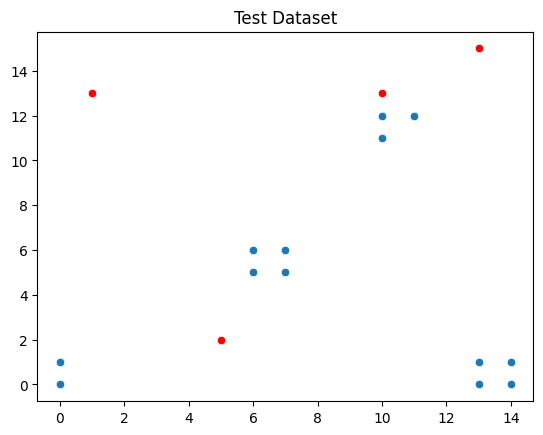

In [23]:
evaluate_qbm(qbm,testing_dataset,4,plot=True,quantile=0.93,method='mean')